In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Read all Data
books = pd.read_csv("books.csv")
tags = pd.read_csv("tags.csv")
booktags = pd.read_csv("book_tags.csv")
ratings = pd.read_csv("ratings.csv")


In [210]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [211]:
booktags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


Book data consists of book features like ids, rating counts, authors, editions etc. The booktags data consists of the tags associated to each book id and count of each tag. This is comprehensive information which can help us to associate three most popular tags associated with each book.

In [17]:
#cleaning book data (check for duplicates)
lastid = books.iloc[-1]['id']
#number of unique book ids
books.groupby('book_id').count()[books.groupby('book_id').count()['id'] > 1]

,id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
book_id,,,,,,,,,,,,,,,,,,,,,


In [29]:
#cleaning ratingsdata (checking for duplicates)
duplicateRatings = ratings.groupby(['user_id','book_id']).size()[ratings.groupby(['user_id','book_id']).size() > 1]

In [48]:
cleanRatings = ratings[ratings['user_id'].apply(lambda x:not( x in duplicateRatings.reset_index()['user_id']))].copy()

In [45]:
duplicateRatings.reset_index()['user_id']

0           7
1          16
2          17
3          25
4          25
        ...  
2204    53139
2205    53186
2206    53292
2207    53331
2208    53338
Name: user_id, Length: 2209, dtype: int64

In [50]:
cleanRatings

,book_id,user_id,rating
6,1,2487,4
7,1,2900,5
8,1,3662,4
9,1,3922,5
10,1,5379,5
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


In [216]:
cleanRatings.reset_index(inplace = True)

Exploratory Data Analysis

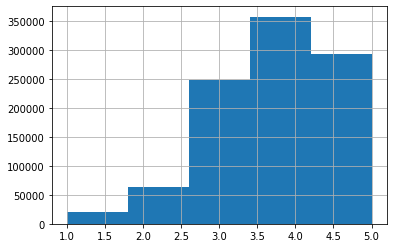

In [52]:
#Distribution of Ratings given by users
ratings['rating'].hist(bins = 5)

The data here is not fully normal. This should be taken care of because dependent variable in collaborative filtering/content based algo should be normally distributed. To do - while model preparation

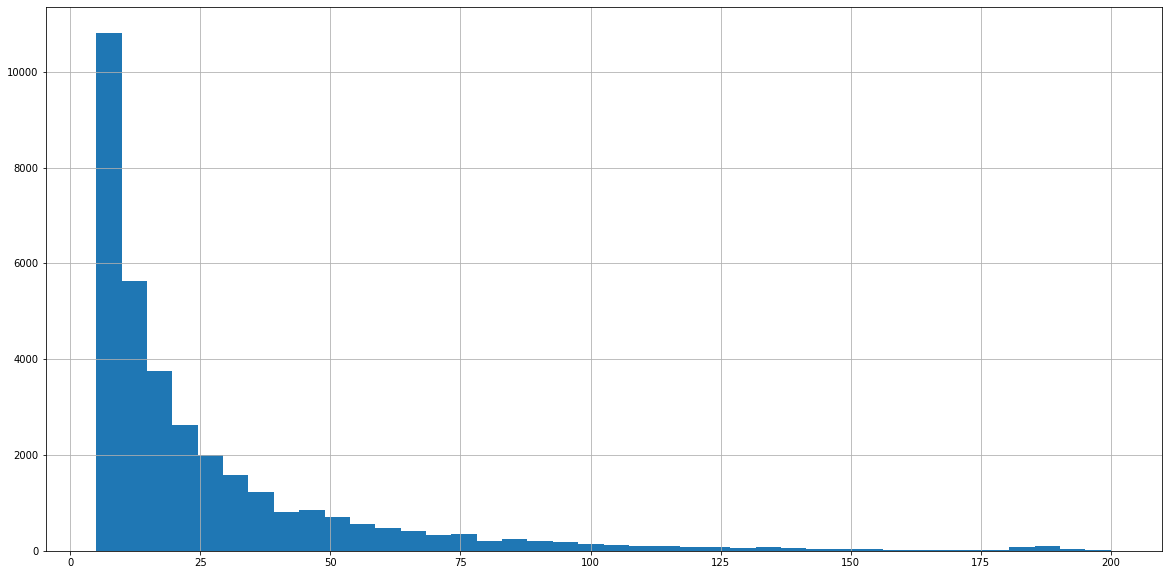

In [214]:
#number of books rated by the users
fig, axes = plt.subplots(figsize = (20,10))
cleanRatings.groupby('user_id').count()['book_id'].hist(bins = 40)

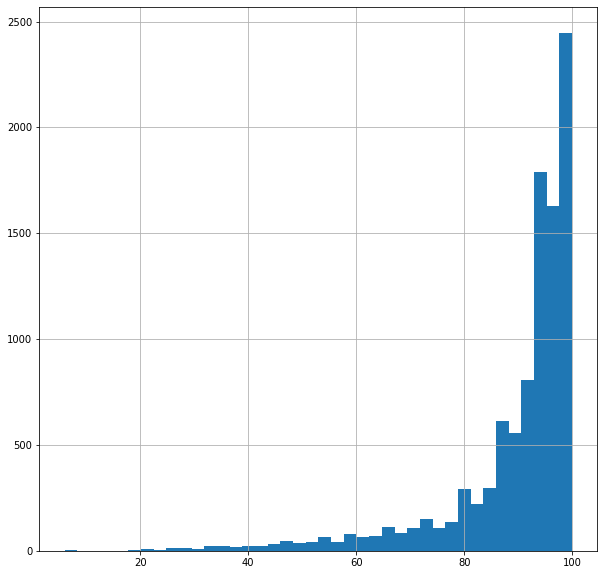

In [217]:
#number of users who rated each book i.e. popularity
fig, axes = plt.subplots(figsize = (10,10))
cleanRatings.groupby('book_id').count()['user_id'].hist(bins = 40)

In [218]:
ratingsbelow40 =  cleanRatings.groupby('book_id').count()['user_id'].apply(lambda x: x < 40)


In [78]:
len(ratingsbelow40[ratingsbelow40 == True])

48

We see that only 5 books out of 10000 have a rating given by less than 40 users. so there is no need to remove less popular books. On the other hand, we can remove users who have given less number of ratings so that collaborative filtering algo does not deal with sparse data, LEADS TO Overfitting.

In [79]:
usersbelow5Ratings =  cleanRatings.groupby('user_id').count()['book_id'].apply(lambda x: x < 5)

In [80]:
len(usersbelow5Ratings[usersbelow5Ratings == True])

17041

In [88]:
#removing 17041 users from cleanData

for index in usersbelow5Ratings[usersbelow5Ratings == True].index:
    cleanRatings.drop(index ,axis = 0, inplace = True)
    

In [220]:
books.shape

(10000, 23)

In [3]:
#Joining Book tags and tags 
booktagsnew = booktags.join(tags, on='tag_id', how='inner',lsuffix='original')
booktagsnew

,goodreads_book_id,tag_idoriginal,count,tag_id,tag_name
0,1,30574,167697,30574,to-read
100,2,30574,24549,30574,to-read
200,3,30574,496107,30574,to-read
304,5,30574,11909,30574,to-read
478,6,30574,298,30574,to-read
...,...,...,...,...,...
999411,31538635,14690,6,14690,hogwarts
999738,32848471,16149,21,16149,jan-2017
999897,33288638,27821,9,27821,single-mom
999910,33288638,11478,7,11478,fave-author


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
porterStemmer = PorterStemmer()

In [5]:
import string

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Stemming the words to the root
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [porterStemmer.stem(word.strip()) for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [6]:
from collections import Counter

In [7]:
c = Counter()
for xs in booktagsnew['tag_name'].dropna():
    for x in text_process(xs):
        c[x]+=1

In [109]:
c.most_common(400)

[('ebook', 24814),
 ('audiobook', 22102),
 ('favorit', 13253),
 ('toread', 9994),
 ('own', 9881),
 ('booksiown', 9807),
 ('currentlyread', 9776),
 ('novel', 9768),
 ('librari', 9426),
 ('ownedbook', 9244),
 ('fiction', 9112),
 ('tobuy', 8694),
 ('kindl', 8317),
 ('default', 8239),
 ('mybook', 7609),
 ('wishlist', 7192),
 ('favourit', 7122),
 ('mylibrari', 7031),
 ('iown', 6673),
 ('adult', 6609),
 ('audio', 6549),
 ('bookclub', 6156),
 ('reread', 5670),
 ('ownit', 5514),
 ('contemporari', 5302),
 ('readin2015', 5239),
 ('mysteri', 5167),
 ('book', 5155),
 ('seri', 5084),
 ('readin2016', 4942),
 ('readin2014', 4902),
 ('classic', 4791),
 ('adultfict', 4776),
 ('readin2013', 4384),
 ('audibl', 4348),
 ('romanc', 4339),
 ('librarybook', 4276),
 ('fantasi', 4265),
 ('abandon', 4183),
 ('youngadult', 4168),
 ('scififantasi', 4145),
 ('children', 4006),
 ('nonfict', 3966),
 ('thriller', 3876),
 ('adventur', 3701),
 ('borrow', 3693),
 ('readin2012', 3661),
 ('english', 3625),
 ('didnotfinish'

In [8]:
genres = ["Auto/Biography","Classics","Fantasy", "Fiction", "Humor and Comedy", "Non-Fiction", "Romance", "Science Fiction",
          "Suspense", "Thriller","Non-Fiction"]
genre_dict = {"Suspense": ['mysteri', 'magic', 'suspens', 'mysterythril','mysterysuspens','mysterycrim','murder','murdermysteri'],
              "Horror" : ['paranorm','horror','supernatur','fantasyparanorm'],
              "Classics":['classic', 'alltimefavorit','classicliteratur','classicstoread'],
              "Fiction": ['adultfict','fiction','generalfict','realisticfict','literaryfict','speculativefict','crimefict','teenfict',
                         'historicalfict'],
              "Fantasy" : ['fantasi','urbanfantasi','yafantasi','highfantasi','sffantasi','epicfantasi'],
              "Thriller": ['thriller', 'adventur','actionadventur','crimethril','crime','suspensethril'],
              "Romance" : ['youngadult', 'romanc', 'love', 'school', 'teen','chicklit','youngadultfict','comingofag','contemporaryrom'],
              "Humor and Comedy" : ['humor','funni','humour','comedi','comic'],
              "Science Fiction" : ['sciencefict', 'fantasyscifi', 'scifi', 'scififantasi','sciencefictionfantasi','scifiandfantasi'],
              "Auto/Biography" : ['memoir','autobiographi','biographymemoir','memoirbiographi'],
              "Non-Fiction" : ['psycholog','nonfic', 'nonfict','religion','adultnonfict','selfhelp','educ','philosophi','religi'],
              "Untagged":[]}

In [9]:
genres = pd.DataFrame(data = np.zeros((10000,11)),columns=["Auto/Biography","Classics","Fantasy", "Fiction", "Humor and Comedy", "Nonfiction", "Romance", "Science Fiction",
          "Suspense", "Thriller","Non-Fiction"])
books = pd.concat([genres, books],axis = 1)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
Auto/Biography               10000 non-null float64
Classics                     10000 non-null float64
Fantasy                      10000 non-null float64
Fiction                      10000 non-null float64
Humor and Comedy             10000 non-null float64
Nonfiction                   10000 non-null float64
Romance                      10000 non-null float64
Science Fiction              10000 non-null float64
Suspense                     10000 non-null float64
Thriller                     10000 non-null float64
Non-Fiction                  10000 non-null float64
id                           10000 non-null int64
book_id                      10000 non-null int64
best_book_id                 10000 non-null int64
work_id                      10000 non-null int64
books_count                  10000 non-null int64
isbn                         9300 non-null object
isbn13              

In [10]:
def simplifyGenre(text):
    bagofWords = text_process(text)
    keyword = ''
    for word in bagofWords:
        keyword = findSimilarWord(word)
        if (keyword!= ''):
            break
    return keyword

In [11]:
def findSimilarWord(word):
    if word in genre_dict.keys():
        return word
    else:
        for x, y in genre_dict.items():
            if word in y:
                return x
        return ''

In [12]:
#Trial Run
i = 0
for index,row in booktagsnew[booktagsnew['goodreads_book_id'] == 105].sort_values('count', ascending = False).iterrows():
    genre = simplifyGenre(row['tag_name'])
    if genre != "" :
        print(genre)
        i = i+1
    if i == 3:
        break

Science Fiction
Science Fiction
Fiction


In [13]:
books.set_index('book_id',inplace=True)
bookids = booktagsnew.groupby('goodreads_book_id').count().index
for id in bookids:
    i = 0
    abooktags = booktagsnew[booktagsnew['goodreads_book_id'] == id].sort_values('count', ascending = False)
    for index,row in abooktags.iterrows():
        genre = simplifyGenre(row['tag_name'])
        if genre != "" :
            books.at[id,genre] = 1
            print("book" + "assigned genre   " + genre)
            print(id)
            i = i + 1
        if i == 3:
            break

            

bookassigned genre   Fantasy
1
bookassigned genre   Romance
1
bookassigned genre   Fiction
1
bookassigned genre   Fantasy
2
bookassigned genre   Classics
2
bookassigned genre   Fiction
2
bookassigned genre   Fantasy
3
bookassigned genre   Romance
3
bookassigned genre   Fiction
3
bookassigned genre   Fantasy
5
bookassigned genre   Romance
5
bookassigned genre   Fiction
5
bookassigned genre   Fantasy
6
bookassigned genre   Romance
6
bookassigned genre   Fiction
6
bookassigned genre   Fantasy
8
bookassigned genre   Romance
8
bookassigned genre   Fiction
8
bookassigned genre   Fantasy
10
bookassigned genre   Fiction
10
bookassigned genre   Romance
10
bookassigned genre   Science Fiction
11
bookassigned genre   Science Fiction
11
bookassigned genre   Fiction
11
bookassigned genre   Science Fiction
13
bookassigned genre   Science Fiction
13
bookassigned genre   Fiction
13
bookassigned genre   Non-Fiction
21
bookassigned genre   Non-Fiction
21
bookassigned genre   Humor and Comedy
21
bookassi

bookassigned genre   Fiction
870
bookassigned genre   Science Fiction
870
bookassigned genre   Romance
870
bookassigned genre   Fiction
880
bookassigned genre   Fiction
880
bookassigned genre   Thriller
880
bookassigned genre   Classics
890
bookassigned genre   Fiction
890
bookassigned genre   Classics
890
bookassigned genre   Non-Fiction
900
bookassigned genre   Non-Fiction
900
bookassigned genre   Non-Fiction
900
bookassigned genre   Suspense
902
bookassigned genre   Romance
902
bookassigned genre   Fiction
902
bookassigned genre   Fiction
903
bookassigned genre   Romance
903
bookassigned genre   Suspense
903
bookassigned genre   Fiction
930
bookassigned genre   Fiction
930
bookassigned genre   Romance
930
bookassigned genre   Non-Fiction
952
bookassigned genre   Non-Fiction
952
bookassigned genre   Non-Fiction
952
bookassigned genre   Fiction
960
bookassigned genre   Suspense
960
bookassigned genre   Thriller
960
bookassigned genre   Fiction
968
bookassigned genre   Thriller
968
boo

bookassigned genre   Suspense
2142
bookassigned genre   Fiction
2142
bookassigned genre   Thriller
2142
bookassigned genre   Fiction
2152
bookassigned genre   Romance
2152
bookassigned genre   Romance
2152
bookassigned genre   Classics
2156
bookassigned genre   Fiction
2156
bookassigned genre   Romance
2156
bookassigned genre   Non-Fiction
2159
bookassigned genre   Non-Fiction
2159
bookassigned genre   Auto/Biography
2159
bookassigned genre   Classics
2165
bookassigned genre   Fiction
2165
bookassigned genre   Classics
2165
bookassigned genre   Classics
2175
bookassigned genre   Fiction
2175
bookassigned genre   Classics
2175
bookassigned genre   Fiction
2183
bookassigned genre   Classics
2183
bookassigned genre   Classics
2183
bookassigned genre   Fiction
2187
bookassigned genre   Fiction
2187
bookassigned genre   Fiction
2187
bookassigned genre   Non-Fiction
2199
bookassigned genre   Non-Fiction
2199
bookassigned genre   Auto/Biography
2199
bookassigned genre   Non-Fiction
2203
booka

bookassigned genre   Fiction
3656
bookassigned genre   Fiction
3656
bookassigned genre   Fiction
3656
bookassigned genre   Fiction
3679
bookassigned genre   Fiction
3679
bookassigned genre   Fiction
3679
bookassigned genre   Fantasy
3682
bookassigned genre   Romance
3682
bookassigned genre   Horror
3682
bookassigned genre   Classics
3685
bookassigned genre   Fiction
3685
bookassigned genre   Classics
3685
bookassigned genre   Non-Fiction
3686
bookassigned genre   Non-Fiction
3686
bookassigned genre   Auto/Biography
3686
bookassigned genre   Fiction
3690
bookassigned genre   Classics
3690
bookassigned genre   Fiction
3690
bookassigned genre   Classics
3692
bookassigned genre   Fiction
3692
bookassigned genre   Classics
3692
bookassigned genre   Fiction
3698
bookassigned genre   Classics
3698
bookassigned genre   Fiction
3698
bookassigned genre   Fiction
3710
bookassigned genre   Fiction
3710
bookassigned genre   Fiction
3710
bookassigned genre   Fiction
3711
bookassigned genre   Fiction

bookassigned genre   Fiction
4656
bookassigned genre   Fiction
4656
bookassigned genre   Fiction
4657
bookassigned genre   Humor and Comedy
4657
bookassigned genre   Fiction
4657
bookassigned genre   Fiction
4659
bookassigned genre   Fiction
4659
bookassigned genre   Fiction
4659
bookassigned genre   Fiction
4660
bookassigned genre   Fiction
4660
bookassigned genre   Fiction
4660
bookassigned genre   Classics
4662
bookassigned genre   Fiction
4662
bookassigned genre   Classics
4662
bookassigned genre   Classics
4671
bookassigned genre   Fiction
4671
bookassigned genre   Classics
4671
bookassigned genre   Fiction
4687
bookassigned genre   Fiction
4687
bookassigned genre   Classics
4687
bookassigned genre   Fiction
4692
bookassigned genre   Fiction
4692
bookassigned genre   Thriller
4692
bookassigned genre   Fiction
4701
bookassigned genre   Humor and Comedy
4701
bookassigned genre   Humor and Comedy
4701
bookassigned genre   Classics
4708
bookassigned genre   Fiction
4708
bookassigned g

bookassigned genre   Fiction
5191
bookassigned genre   Romance
5191
bookassigned genre   Suspense
5191
bookassigned genre   Romance
5196
bookassigned genre   Romance
5196
bookassigned genre   Fiction
5196
bookassigned genre   Fiction
5197
bookassigned genre   Classics
5197
bookassigned genre   Fiction
5197
bookassigned genre   Fiction
5198
bookassigned genre   Classics
5198
bookassigned genre   Fiction
5198
bookassigned genre   Fiction
5203
bookassigned genre   Romance
5203
bookassigned genre   Fiction
5203
bookassigned genre   Fiction
5204
bookassigned genre   Fiction
5204
bookassigned genre   Fiction
5204
bookassigned genre   Fiction
5205
bookassigned genre   Fiction
5205
bookassigned genre   Fiction
5205
bookassigned genre   Fiction
5211
bookassigned genre   Fiction
5211
bookassigned genre   Fiction
5211
bookassigned genre   Classics
5246
bookassigned genre   Fiction
5246
bookassigned genre   Classics
5246
bookassigned genre   Classics
5289
bookassigned genre   Fiction
5289
bookassi

bookassigned genre   Romance
6310
bookassigned genre   Classics
6310
bookassigned genre   Fantasy
6319
bookassigned genre   Classics
6319
bookassigned genre   Humor and Comedy
6319
bookassigned genre   Fantasy
6327
bookassigned genre   Fiction
6327
bookassigned genre   Romance
6327
bookassigned genre   Fiction
6328
bookassigned genre   Fantasy
6328
bookassigned genre   Humor and Comedy
6328
bookassigned genre   Fiction
6334
bookassigned genre   Science Fiction
6334
bookassigned genre   Science Fiction
6334
bookassigned genre   Suspense
6419
bookassigned genre   Fiction
6419
bookassigned genre   Humor and Comedy
6419
bookassigned genre   Suspense
6420
bookassigned genre   Fiction
6420
bookassigned genre   Humor and Comedy
6420
bookassigned genre   Suspense
6422
bookassigned genre   Fiction
6422
bookassigned genre   Humor and Comedy
6422
bookassigned genre   Suspense
6423
bookassigned genre   Fiction
6423
bookassigned genre   Humor and Comedy
6423
bookassigned genre   Suspense
6424
booka

bookassigned genre   Fiction
7437
bookassigned genre   Classics
7437
bookassigned genre   Classics
7437
bookassigned genre   Non-Fiction
7442
bookassigned genre   Fiction
7442
bookassigned genre   Non-Fiction
7442
bookassigned genre   Non-Fiction
7445
bookassigned genre   Auto/Biography
7445
bookassigned genre   Non-Fiction
7445
bookassigned genre   Romance
7455
bookassigned genre   Fiction
7455
bookassigned genre   Romance
7455
bookassigned genre   Non-Fiction
7493
bookassigned genre   Non-Fiction
7493
bookassigned genre   Romance
7493
bookassigned genre   Romance
7494
bookassigned genre   Fiction
7494
bookassigned genre   Romance
7494
bookassigned genre   Suspense
7510
bookassigned genre   Fiction
7510
bookassigned genre   Thriller
7510
bookassigned genre   Thriller
7520
bookassigned genre   Fiction
7520
bookassigned genre   Thriller
7520
bookassigned genre   Humor and Comedy
7531
bookassigned genre   Non-Fiction
7531
bookassigned genre   Auto/Biography
7531
bookassigned genre   Fict

8648
bookassigned genre   Science Fiction
8648
bookassigned genre   Fiction
8648
bookassigned genre   Fiction
8650
bookassigned genre   Science Fiction
8650
bookassigned genre   Thriller
8650
bookassigned genre   Non-Fiction
8676
bookassigned genre   Non-Fiction
8676
bookassigned genre   Non-Fiction
8676
bookassigned genre   Fiction
8680
bookassigned genre   Humor and Comedy
8680
bookassigned genre   Humor and Comedy
8680
bookassigned genre   Fiction
8682
bookassigned genre   Humor and Comedy
8682
bookassigned genre   Classics
8682
bookassigned genre   Science Fiction
8694
bookassigned genre   Science Fiction
8694
bookassigned genre   Fiction
8694
bookassigned genre   Science Fiction
8695
bookassigned genre   Science Fiction
8695
bookassigned genre   Fiction
8695
bookassigned genre   Non-Fiction
8696
bookassigned genre   Non-Fiction
8696
bookassigned genre   Humor and Comedy
8696
bookassigned genre   Science Fiction
8698
bookassigned genre   Science Fiction
8698
bookassigned genre   Fi

bookassigned genre   Fiction
9822
bookassigned genre   Romance
9822
bookassigned genre   Fiction
9827
bookassigned genre   Fiction
9827
bookassigned genre   Classics
9827
bookassigned genre   Fiction
9833
bookassigned genre   Fantasy
9833
bookassigned genre   Fiction
9833
bookassigned genre   Non-Fiction
9838
bookassigned genre   Auto/Biography
9838
bookassigned genre   Auto/Biography
9838
bookassigned genre   Fiction
9844
bookassigned genre   Romance
9844
bookassigned genre   Romance
9844
bookassigned genre   Non-Fiction
9854
bookassigned genre   Non-Fiction
9854
bookassigned genre   Non-Fiction
9854
bookassigned genre   Fiction
9864
bookassigned genre   Romance
9864
bookassigned genre   Fiction
9864
bookassigned genre   Fiction
9865
bookassigned genre   Fiction
9865
bookassigned genre   Fiction
9865
bookassigned genre   Fiction
9912
bookassigned genre   Fiction
9912
bookassigned genre   Fiction
9912
bookassigned genre   Fiction
9913
bookassigned genre   Thriller
9913
bookassigned gen

10882
bookassigned genre   Auto/Biography
10882
bookassigned genre   Non-Fiction
10883
bookassigned genre   Non-Fiction
10883
bookassigned genre   Auto/Biography
10883
bookassigned genre   Non-Fiction
10884
bookassigned genre   Non-Fiction
10884
bookassigned genre   Auto/Biography
10884
bookassigned genre   Non-Fiction
10890
bookassigned genre   Auto/Biography
10890
bookassigned genre   Non-Fiction
10890
bookassigned genre   Non-Fiction
10907
bookassigned genre   Non-Fiction
10907
bookassigned genre   Auto/Biography
10907
bookassigned genre   Romance
10908
bookassigned genre   Romance
10908
bookassigned genre   Fiction
10908
bookassigned genre   Fiction
10909
bookassigned genre   Romance
10909
bookassigned genre   Fiction
10909
bookassigned genre   Fiction
10910
bookassigned genre   Romance
10910
bookassigned genre   Romance
10910
bookassigned genre   Fiction
10911
bookassigned genre   Suspense
10911
bookassigned genre   Romance
10911
bookassigned genre   Fiction
10912
bookassigned gen

bookassigned genre   Horror
11597
bookassigned genre   Horror
11602
bookassigned genre   Fiction
11602
bookassigned genre   Fantasy
11602
bookassigned genre   Fiction
11605
bookassigned genre   Horror
11605
bookassigned genre   Fantasy
11605
bookassigned genre   Horror
11607
bookassigned genre   Science Fiction
11607
bookassigned genre   Science Fiction
11607
bookassigned genre   Non-Fiction
11623
bookassigned genre   Non-Fiction
11623
bookassigned genre   Auto/Biography
11623
bookassigned genre   Fiction
11650
bookassigned genre   Classics
11650
bookassigned genre   Fiction
11650
bookassigned genre   Fiction
11666
bookassigned genre   Classics
11666
bookassigned genre   Fiction
11666
bookassigned genre   Fiction
11686
bookassigned genre   Classics
11686
bookassigned genre   Fiction
11686
bookassigned genre   Non-Fiction
11690
bookassigned genre   Fiction
11690
bookassigned genre   Auto/Biography
11690
bookassigned genre   Fiction
11691
bookassigned genre   Fiction
11691
bookassigned g

bookassigned genre   Fiction
12914
bookassigned genre   Classics
12914
bookassigned genre   Classics
12923
bookassigned genre   Horror
12923
bookassigned genre   Fiction
12923
bookassigned genre   Romance
12930
bookassigned genre   Fiction
12930
bookassigned genre   Fantasy
12930
bookassigned genre   Fiction
12936
bookassigned genre   Romance
12936
bookassigned genre   Science Fiction
12936
bookassigned genre   Classics
12938
bookassigned genre   Fiction
12938
bookassigned genre   Classics
12938
bookassigned genre   Horror
12948
bookassigned genre   Fiction
12948
bookassigned genre   Classics
12948
bookassigned genre   Classics
12957
bookassigned genre   Fiction
12957
bookassigned genre   Classics
12957
bookassigned genre   Fantasy
12967
bookassigned genre   Fiction
12967
bookassigned genre   Fiction
12967
bookassigned genre   Classics
12985
bookassigned genre   Classics
12985
bookassigned genre   Fiction
12985
bookassigned genre   Classics
12996
bookassigned genre   Fiction
12996
book

bookassigned genre   Romance
13836
bookassigned genre   Suspense
13836
bookassigned genre   Fantasy
13837
bookassigned genre   Romance
13837
bookassigned genre   Fiction
13837
bookassigned genre   Non-Fiction
13839
bookassigned genre   Non-Fiction
13839
bookassigned genre   Non-Fiction
13839
bookassigned genre   Fiction
13872
bookassigned genre   Horror
13872
bookassigned genre   Fantasy
13872
bookassigned genre   Fantasy
13878
bookassigned genre   Fiction
13878
bookassigned genre   Fantasy
13878
bookassigned genre   Fantasy
13881
bookassigned genre   Fiction
13881
bookassigned genre   Fantasy
13881
bookassigned genre   Fantasy
13888
bookassigned genre   Fiction
13888
bookassigned genre   Science Fiction
13888
bookassigned genre   Fantasy
13890
bookassigned genre   Fiction
13890
bookassigned genre   Fantasy
13890
bookassigned genre   Fantasy
13891
bookassigned genre   Fiction
13891
bookassigned genre   Fantasy
13891
bookassigned genre   Fantasy
13895
bookassigned genre   Fiction
13895


bookassigned genre   Non-Fiction
15196
bookassigned genre   Non-Fiction
15196
bookassigned genre   Humor and Comedy
15197
bookassigned genre   Non-Fiction
15197
bookassigned genre   Auto/Biography
15197
bookassigned genre   Fantasy
15241
bookassigned genre   Classics
15241
bookassigned genre   Fiction
15241
bookassigned genre   Fantasy
15309
bookassigned genre   Fantasy
15309
bookassigned genre   Horror
15309
bookassigned genre   Fiction
15398
bookassigned genre   Fiction
15398
bookassigned genre   Fiction
15398
bookassigned genre   Fantasy
15433
bookassigned genre   Fiction
15433
bookassigned genre   Humor and Comedy
15433
bookassigned genre   Fantasy
15447
bookassigned genre   Fiction
15447
bookassigned genre   Humor and Comedy
15447
bookassigned genre   Fantasy
15547
bookassigned genre   Fiction
15547
bookassigned genre   Science Fiction
15547
bookassigned genre   Fantasy
15549
bookassigned genre   Fiction
15549
bookassigned genre   Science Fiction
15549
bookassigned genre   Fantasy

bookassigned genre   Horror
16429
bookassigned genre   Horror
16431
bookassigned genre   Fiction
16431
bookassigned genre   Thriller
16431
bookassigned genre   Horror
16433
bookassigned genre   Fiction
16433
bookassigned genre   Suspense
16433
bookassigned genre   Horror
16434
bookassigned genre   Fiction
16434
bookassigned genre   Thriller
16434
bookassigned genre   Horror
16435
bookassigned genre   Fiction
16435
bookassigned genre   Thriller
16435
bookassigned genre   Fiction
16527
bookassigned genre   Fiction
16527
bookassigned genre   Romance
16527
bookassigned genre   Fiction
16532
bookassigned genre   Fiction
16532
bookassigned genre   Romance
16532
bookassigned genre   Non-Fiction
16619
bookassigned genre   Non-Fiction
16619
bookassigned genre   Classics
16619
bookassigned genre   Fiction
16631
bookassigned genre   Classics
16631
bookassigned genre   Non-Fiction
16631
bookassigned genre   Fiction
16634
bookassigned genre   Classics
16634
bookassigned genre   Non-Fiction
16634
bo

bookassigned genre   Fiction
17876
bookassigned genre   Non-Fiction
17876
bookassigned genre   Classics
17877
bookassigned genre   Fiction
17877
bookassigned genre   Classics
17877
bookassigned genre   Fiction
17961
bookassigned genre   Classics
17961
bookassigned genre   Fantasy
17961
bookassigned genre   Non-Fiction
17977
bookassigned genre   Non-Fiction
17977
bookassigned genre   Non-Fiction
17977
bookassigned genre   Non-Fiction
17994
bookassigned genre   Non-Fiction
17994
bookassigned genre   Non-Fiction
17994
bookassigned genre   Fiction
18005
bookassigned genre   Thriller
18005
bookassigned genre   Fantasy
18005
bookassigned genre   Fiction
18035
bookassigned genre   Humor and Comedy
18035
bookassigned genre   Humor and Comedy
18035
bookassigned genre   Romance
18116
bookassigned genre   Fiction
18116
bookassigned genre   Science Fiction
18116
bookassigned genre   Fantasy
18122
bookassigned genre   Romance
18122
bookassigned genre   Fiction
18122
bookassigned genre   Fantasy
181

bookassigned genre   Horror
19581
bookassigned genre   Fiction
19581
bookassigned genre   Horror
19581
bookassigned genre   Non-Fiction
19596
bookassigned genre   Non-Fiction
19596
bookassigned genre   Non-Fiction
19596
bookassigned genre   Fiction
19631
bookassigned genre   Fiction
19631
bookassigned genre   Fiction
19631
bookassigned genre   Fiction
19661
bookassigned genre   Fiction
19661
bookassigned genre   Fiction
19661
bookassigned genre   Fiction
19668
bookassigned genre   Thriller
19668
bookassigned genre   Suspense
19668
bookassigned genre   Fiction
19670
bookassigned genre   Thriller
19670
bookassigned genre   Thriller
19670
bookassigned genre   Fiction
19674
bookassigned genre   Thriller
19674
bookassigned genre   Thriller
19674
bookassigned genre   Fiction
19675
bookassigned genre   Thriller
19675
bookassigned genre   Thriller
19675
bookassigned genre   Fiction
19687
bookassigned genre   Thriller
19687
bookassigned genre   Suspense
19687
bookassigned genre   Fiction
19688


bookassigned genre   Science Fiction
22420
bookassigned genre   Fiction
22420
bookassigned genre   Humor and Comedy
22421
bookassigned genre   Science Fiction
22421
bookassigned genre   Fiction
22421
bookassigned genre   Non-Fiction
22435
bookassigned genre   Non-Fiction
22435
bookassigned genre   Non-Fiction
22435
bookassigned genre   Non-Fiction
22463
bookassigned genre   Classics
22463
bookassigned genre   Non-Fiction
22463
bookassigned genre   Humor and Comedy
22469
bookassigned genre   Fiction
22469
bookassigned genre   Fantasy
22469
bookassigned genre   Non-Fiction
22543
bookassigned genre   Non-Fiction
22543
bookassigned genre   Non-Fiction
22543
bookassigned genre   Science Fiction
22584
bookassigned genre   Science Fiction
22584
bookassigned genre   Fiction
22584
bookassigned genre   Science Fiction
22590
bookassigned genre   Science Fiction
22590
bookassigned genre   Fiction
22590
bookassigned genre   Fiction
22628
bookassigned genre   Romance
22628
bookassigned genre   Ficti

bookassigned genre   Science Fiction
24765
bookassigned genre   Romance
24766
bookassigned genre   Fantasy
24766
bookassigned genre   Horror
24766
bookassigned genre   Romance
24767
bookassigned genre   Fantasy
24767
bookassigned genre   Horror
24767
bookassigned genre   Romance
24768
bookassigned genre   Science Fiction
24768
bookassigned genre   Science Fiction
24768
bookassigned genre   Romance
24769
bookassigned genre   Fantasy
24769
bookassigned genre   Horror
24769
bookassigned genre   Romance
24770
bookassigned genre   Science Fiction
24770
bookassigned genre   Science Fiction
24770
bookassigned genre   Fantasy
24779
bookassigned genre   Romance
24779
bookassigned genre   Fiction
24779
bookassigned genre   Fantasy
24780
bookassigned genre   Romance
24780
bookassigned genre   Fiction
24780
bookassigned genre   Fantasy
24781
bookassigned genre   Romance
24781
bookassigned genre   Fiction
24781
bookassigned genre   Fantasy
24782
bookassigned genre   Romance
24782
bookassigned genre

bookassigned genre   Non-Fiction
27397
bookassigned genre   Fiction
27397
bookassigned genre   Non-Fiction
27398
bookassigned genre   Non-Fiction
27398
bookassigned genre   Suspense
27398
bookassigned genre   Classics
27494
bookassigned genre   Fiction
27494
bookassigned genre   Non-Fiction
27494
bookassigned genre   Fantasy
27523
bookassigned genre   Non-Fiction
27523
bookassigned genre   Fiction
27523
bookassigned genre   Fiction
27525
bookassigned genre   Non-Fiction
27525
bookassigned genre   Non-Fiction
27525
bookassigned genre   Fiction
27526
bookassigned genre   Non-Fiction
27526
bookassigned genre   Non-Fiction
27526
bookassigned genre   Fiction
27528
bookassigned genre   Non-Fiction
27528
bookassigned genre   Non-Fiction
27528
bookassigned genre   Fiction
27530
bookassigned genre   Non-Fiction
27530
bookassigned genre   Non-Fiction
27530
bookassigned genre   Fantasy
27712
bookassigned genre   Classics
27712
bookassigned genre   Fiction
27712
bookassigned genre   Romance
27822


bookassigned genre   Fiction
29925
bookassigned genre   Fiction
29925
bookassigned genre   Non-Fiction
29925
bookassigned genre   Fiction
29946
bookassigned genre   Non-Fiction
29946
bookassigned genre   Classics
29946
bookassigned genre   Fiction
29948
bookassigned genre   Romance
29948
bookassigned genre   Non-Fiction
29948
bookassigned genre   Horror
29981
bookassigned genre   Classics
29981
bookassigned genre   Fiction
29981
bookassigned genre   Suspense
29999
bookassigned genre   Fiction
29999
bookassigned genre   Classics
29999
bookassigned genre   Suspense
30005
bookassigned genre   Fiction
30005
bookassigned genre   Thriller
30005
bookassigned genre   Science Fiction
30013
bookassigned genre   Science Fiction
30013
bookassigned genre   Fiction
30013
bookassigned genre   Science Fiction
30016
bookassigned genre   Fiction
30016
bookassigned genre   Science Fiction
30016
bookassigned genre   Fantasy
30036
bookassigned genre   Fiction
30036
bookassigned genre   Science Fiction
3003

bookassigned genre   Classics
31250
bookassigned genre   Fiction
31250
bookassigned genre   Classics
31250
bookassigned genre   Fiction
31259
bookassigned genre   Thriller
31259
bookassigned genre   Suspense
31259
bookassigned genre   Fiction
31266
bookassigned genre   Thriller
31266
bookassigned genre   Suspense
31266
bookassigned genre   Thriller
31268
bookassigned genre   Fiction
31268
bookassigned genre   Suspense
31268
bookassigned genre   Thriller
31271
bookassigned genre   Fiction
31271
bookassigned genre   Suspense
31271
bookassigned genre   Suspense
31300
bookassigned genre   Fiction
31300
bookassigned genre   Thriller
31300
bookassigned genre   Suspense
31304
bookassigned genre   Fiction
31304
bookassigned genre   Thriller
31304
bookassigned genre   Non-Fiction
31312
bookassigned genre   Non-Fiction
31312
bookassigned genre   Non-Fiction
31312
bookassigned genre   Romance
31313
bookassigned genre   Fantasy
31313
bookassigned genre   Horror
31313
bookassigned genre   Fiction
3

bookassigned genre   Fiction
32692
bookassigned genre   Thriller
32692
bookassigned genre   Suspense
32692
bookassigned genre   Horror
32767
bookassigned genre   Fiction
32767
bookassigned genre   Classics
32767
bookassigned genre   Horror
32769
bookassigned genre   Fiction
32769
bookassigned genre   Fantasy
32769
bookassigned genre   Fiction
32807
bookassigned genre   Thriller
32807
bookassigned genre   Thriller
32807
bookassigned genre   Classics
32812
bookassigned genre   Fiction
32812
bookassigned genre   Classics
32812
bookassigned genre   Classics
32827
bookassigned genre   Science Fiction
32827
bookassigned genre   Fiction
32827
bookassigned genre   Classics
32829
bookassigned genre   Science Fiction
32829
bookassigned genre   Fiction
32829
bookassigned genre   Science Fiction
32831
bookassigned genre   Thriller
32831
bookassigned genre   Classics
32831
bookassigned genre   Classics
32929
bookassigned genre   Fiction
32929
bookassigned genre   Classics
32929
bookassigned genre  

bookassigned genre   Humor and Comedy
34511
bookassigned genre   Fantasy
34511
bookassigned genre   Fantasy
34517
bookassigned genre   Fiction
34517
bookassigned genre   Humor and Comedy
34517
bookassigned genre   Fantasy
34527
bookassigned genre   Fiction
34527
bookassigned genre   Humor and Comedy
34527
bookassigned genre   Fantasy
34529
bookassigned genre   Humor and Comedy
34529
bookassigned genre   Fiction
34529
bookassigned genre   Fantasy
34532
bookassigned genre   Fiction
34532
bookassigned genre   Humor and Comedy
34532
bookassigned genre   Fantasy
34534
bookassigned genre   Fiction
34534
bookassigned genre   Romance
34534
bookassigned genre   Fantasy
34541
bookassigned genre   Fiction
34541
bookassigned genre   Humor and Comedy
34541
bookassigned genre   Non-Fiction
34548
bookassigned genre   Humor and Comedy
34548
bookassigned genre   Non-Fiction
34548
bookassigned genre   Horror
34605
bookassigned genre   Fiction
34605
bookassigned genre   Fantasy
34605
bookassigned genre  

bookassigned genre   Classics
38447
bookassigned genre   Science Fiction
38447
bookassigned genre   Fiction
38462
bookassigned genre   Classics
38462
bookassigned genre   Romance
38462
bookassigned genre   Fiction
38500
bookassigned genre   Classics
38500
bookassigned genre   Humor and Comedy
38500
bookassigned genre   Fiction
38501
bookassigned genre   Classics
38501
bookassigned genre   Romance
38501
bookassigned genre   Fiction
38502
bookassigned genre   Classics
38502
bookassigned genre   Non-Fiction
38502
bookassigned genre   Fiction
38503
bookassigned genre   Classics
38503
bookassigned genre   Non-Fiction
38503
bookassigned genre   Fiction
38505
bookassigned genre   Humor and Comedy
38505
bookassigned genre   Classics
38505
bookassigned genre   Romance
38529
bookassigned genre   Horror
38529
bookassigned genre   Fantasy
38529
bookassigned genre   Romance
38548
bookassigned genre   Horror
38548
bookassigned genre   Fantasy
38548
bookassigned genre   Romance
38562
bookassigned gen

bookassigned genre   Fiction
41219
bookassigned genre   Fiction
41219
bookassigned genre   Romance
41219
bookassigned genre   Fantasy
41424
bookassigned genre   Romance
41424
bookassigned genre   Romance
41424
bookassigned genre   Suspense
41490
bookassigned genre   Fiction
41490
bookassigned genre   Suspense
41490
bookassigned genre   Fiction
41502
bookassigned genre   Fiction
41502
bookassigned genre   Suspense
41502
bookassigned genre   Fiction
41667
bookassigned genre   Romance
41667
bookassigned genre   Thriller
41667
bookassigned genre   Fiction
41681
bookassigned genre   Classics
41681
bookassigned genre   Classics
41681
bookassigned genre   Classics
41684
bookassigned genre   Classics
41684
bookassigned genre   Classics
41684
bookassigned genre   Fiction
41689
bookassigned genre   Fiction
41689
bookassigned genre   Thriller
41689
bookassigned genre   Fiction
41698
bookassigned genre   Thriller
41698
bookassigned genre   Thriller
41698
bookassigned genre   Fiction
41701
bookassi

bookassigned genre   Fiction
43448
bookassigned genre   Horror
43448
bookassigned genre   Romance
43448
bookassigned genre   Classics
43545
bookassigned genre   Fiction
43545
bookassigned genre   Fantasy
43545
bookassigned genre   Fantasy
43615
bookassigned genre   Fiction
43615
bookassigned genre   Horror
43615
bookassigned genre   Fiction
43641
bookassigned genre   Fiction
43641
bookassigned genre   Romance
43641
bookassigned genre   Humor and Comedy
43739
bookassigned genre   Fiction
43739
bookassigned genre   Humor and Comedy
43739
bookassigned genre   Horror
43758
bookassigned genre   Fantasy
43758
bookassigned genre   Fiction
43758
bookassigned genre   Fantasy
43763
bookassigned genre   Horror
43763
bookassigned genre   Fiction
43763
bookassigned genre   Horror
43780
bookassigned genre   Fiction
43780
bookassigned genre   Fantasy
43780
bookassigned genre   Fiction
43781
bookassigned genre   Horror
43781
bookassigned genre   Horror
43781
bookassigned genre   Horror
43782
bookassig

46201
bookassigned genre   Fiction
46201
bookassigned genre   Non-Fiction
46201
bookassigned genre   Fantasy
46202
bookassigned genre   Suspense
46202
bookassigned genre   Romance
46202
bookassigned genre   Fiction
46227
bookassigned genre   Classics
46227
bookassigned genre   Fiction
46227
bookassigned genre   Classics
46292
bookassigned genre   Non-Fiction
46292
bookassigned genre   Non-Fiction
46292
bookassigned genre   Classics
46306
bookassigned genre   Fiction
46306
bookassigned genre   Romance
46306
bookassigned genre   Auto/Biography
46349
bookassigned genre   Non-Fiction
46349
bookassigned genre   Non-Fiction
46349
bookassigned genre   Fiction
46438
bookassigned genre   Thriller
46438
bookassigned genre   Fiction
46438
bookassigned genre   Fiction
46460
bookassigned genre   Suspense
46460
bookassigned genre   Thriller
46460
bookassigned genre   Fiction
46544
bookassigned genre   Fiction
46544
bookassigned genre   Fantasy
46544
bookassigned genre   Fiction
46601
bookassigned ge

bookassigned genre   Fiction
49250
bookassigned genre   Non-Fiction
49251
bookassigned genre   Non-Fiction
49251
bookassigned genre   Auto/Biography
49251
bookassigned genre   Non-Fiction
49322
bookassigned genre   Non-Fiction
49322
bookassigned genre   Non-Fiction
49322
bookassigned genre   Suspense
49350
bookassigned genre   Fiction
49350
bookassigned genre   Thriller
49350
bookassigned genre   Suspense
49353
bookassigned genre   Fiction
49353
bookassigned genre   Thriller
49353
bookassigned genre   Non-Fiction
49436
bookassigned genre   Non-Fiction
49436
bookassigned genre   Auto/Biography
49436
bookassigned genre   Classics
49455
bookassigned genre   Fiction
49455
bookassigned genre   Non-Fiction
49455
bookassigned genre   Fiction
49465
bookassigned genre   Fiction
49465
bookassigned genre   Fiction
49465
bookassigned genre   Classics
49540
bookassigned genre   Fiction
49540
bookassigned genre   Classics
49540
bookassigned genre   Classics
49552
bookassigned genre   Fiction
49552
b

bookassigned genre   Humor and Comedy
53580
bookassigned genre   Suspense
53625
bookassigned genre   Fiction
53625
bookassigned genre   Thriller
53625
bookassigned genre   Fiction
53639
bookassigned genre   Classics
53639
bookassigned genre   Non-Fiction
53639
bookassigned genre   Auto/Biography
53645
bookassigned genre   Non-Fiction
53645
bookassigned genre   Non-Fiction
53645
bookassigned genre   Science Fiction
53764
bookassigned genre   Science Fiction
53764
bookassigned genre   Fiction
53764
bookassigned genre   Non-Fiction
53809
bookassigned genre   Non-Fiction
53809
bookassigned genre   Non-Fiction
53809
bookassigned genre   Non-Fiction
53817
bookassigned genre   Non-Fiction
53817
bookassigned genre   Non-Fiction
53817
bookassigned genre   Non-Fiction
53834
bookassigned genre   Non-Fiction
53834
bookassigned genre   Non-Fiction
53834
bookassigned genre   Classics
53835
bookassigned genre   Fiction
53835
bookassigned genre   Classics
53835
bookassigned genre   Fiction
53926
booka

bookassigned genre   Horror
59821
bookassigned genre   Romance
59822
bookassigned genre   Horror
59822
bookassigned genre   Fiction
59822
bookassigned genre   Romance
59825
bookassigned genre   Romance
59825
bookassigned genre   Fiction
59825
bookassigned genre   Romance
59829
bookassigned genre   Horror
59829
bookassigned genre   Fiction
59829
bookassigned genre   Romance
59830
bookassigned genre   Horror
59830
bookassigned genre   Fiction
59830
bookassigned genre   Romance
59836
bookassigned genre   Fiction
59836
bookassigned genre   Romance
59836
bookassigned genre   Fiction
59882
bookassigned genre   Romance
59882
bookassigned genre   Romance
59882
bookassigned genre   Romance
59887
bookassigned genre   Fiction
59887
bookassigned genre   Romance
59887
bookassigned genre   Romance
59889
bookassigned genre   Fiction
59889
bookassigned genre   Romance
59889
bookassigned genre   Science Fiction
59924
bookassigned genre   Science Fiction
59924
bookassigned genre   Fiction
59924
bookassi

bookassigned genre   Non-Fiction
63832
bookassigned genre   Auto/Biography
63832
bookassigned genre   Non-Fiction
63832
bookassigned genre   Non-Fiction
64023
bookassigned genre   Non-Fiction
64023
bookassigned genre   Non-Fiction
64023
bookassigned genre   Non-Fiction
64081
bookassigned genre   Non-Fiction
64081
bookassigned genre   Non-Fiction
64081
bookassigned genre   Fantasy
64216
bookassigned genre   Fiction
64216
bookassigned genre   Humor and Comedy
64216
bookassigned genre   Fantasy
64217
bookassigned genre   Fiction
64217
bookassigned genre   Humor and Comedy
64217
bookassigned genre   Humor and Comedy
64218
bookassigned genre   Fiction
64218
bookassigned genre   Fantasy
64218
bookassigned genre   Fantasy
64222
bookassigned genre   Fiction
64222
bookassigned genre   Humor and Comedy
64222
bookassigned genre   Science Fiction
64394
bookassigned genre   Science Fiction
64394
bookassigned genre   Fiction
64394
bookassigned genre   Fantasy
64401
bookassigned genre   Humor and Com

bookassigned genre   Fiction
68531
bookassigned genre   Fiction
68531
bookassigned genre   Fantasy
68531
bookassigned genre   Fiction
68591
bookassigned genre   Fantasy
68591
bookassigned genre   Non-Fiction
68591
bookassigned genre   Auto/Biography
68783
bookassigned genre   Non-Fiction
68783
bookassigned genre   Fiction
68783
bookassigned genre   Fiction
68811
bookassigned genre   Classics
68811
bookassigned genre   Romance
68811
bookassigned genre   Suspense
68930
bookassigned genre   Thriller
68930
bookassigned genre   Fiction
68930
bookassigned genre   Non-Fiction
68984
bookassigned genre   Non-Fiction
68984
bookassigned genre   Non-Fiction
68984
bookassigned genre   Non-Fiction
68985
bookassigned genre   Non-Fiction
68985
bookassigned genre   Non-Fiction
68985
bookassigned genre   Fantasy
69136
bookassigned genre   Fiction
69136
bookassigned genre   Romance
69136
bookassigned genre   Non-Fiction
69242
bookassigned genre   Non-Fiction
69242
bookassigned genre   Non-Fiction
69242
b

bookassigned genre   Suspense
74997
bookassigned genre   Fiction
74997
bookassigned genre   Fantasy
74998
bookassigned genre   Fiction
74998
bookassigned genre   Thriller
74998
bookassigned genre   Thriller
75020
bookassigned genre   Fiction
75020
bookassigned genre   Suspense
75020
bookassigned genre   Fiction
75024
bookassigned genre   Thriller
75024
bookassigned genre   Suspense
75024
bookassigned genre   Non-Fiction
75162
bookassigned genre   Auto/Biography
75162
bookassigned genre   Non-Fiction
75162
bookassigned genre   Suspense
76104
bookassigned genre   Classics
76104
bookassigned genre   Fiction
76104
bookassigned genre   Fiction
76171
bookassigned genre   Science Fiction
76171
bookassigned genre   Classics
76171
bookassigned genre   Romance
76179
bookassigned genre   Suspense
76179
bookassigned genre   Suspense
76179
bookassigned genre   Suspense
76237
bookassigned genre   Classics
76237
bookassigned genre   Fiction
76237
bookassigned genre   Suspense
76248
bookassigned genre

bookassigned genre   Fantasy
78411
bookassigned genre   Romance
78411
bookassigned genre   Fiction
78418
bookassigned genre   Romance
78418
bookassigned genre   Fantasy
78418
bookassigned genre   Non-Fiction
78427
bookassigned genre   Non-Fiction
78427
bookassigned genre   Non-Fiction
78427
bookassigned genre   Fiction
78433
bookassigned genre   Fiction
78433
bookassigned genre   Suspense
78433
bookassigned genre   Non-Fiction
78508
bookassigned genre   Non-Fiction
78508
bookassigned genre   Thriller
78508
bookassigned genre   Non-Fiction
78629
bookassigned genre   Non-Fiction
78629
bookassigned genre   Non-Fiction
78629
bookassigned genre   Fiction
78674
bookassigned genre   Fiction
78674
bookassigned genre   Fiction
78674
bookassigned genre   Fiction
78728
bookassigned genre   Non-Fiction
78728
bookassigned genre   Classics
78728
bookassigned genre   Fantasy
78876
bookassigned genre   Fiction
78876
bookassigned genre   Humor and Comedy
78876
bookassigned genre   Classics
78950
bookas

bookassigned genre   Fiction
84119
bookassigned genre   Horror
84132
bookassigned genre   Romance
84132
bookassigned genre   Fantasy
84132
bookassigned genre   Horror
84133
bookassigned genre   Romance
84133
bookassigned genre   Fantasy
84133
bookassigned genre   Horror
84135
bookassigned genre   Romance
84135
bookassigned genre   Fantasy
84135
bookassigned genre   Romance
84136
bookassigned genre   Horror
84136
bookassigned genre   Fantasy
84136
bookassigned genre   Romance
84139
bookassigned genre   Fantasy
84139
bookassigned genre   Horror
84139
bookassigned genre   Horror
84140
bookassigned genre   Romance
84140
bookassigned genre   Fantasy
84140
bookassigned genre   Horror
84142
bookassigned genre   Romance
84142
bookassigned genre   Fantasy
84142
bookassigned genre   Horror
84144
bookassigned genre   Romance
84144
bookassigned genre   Fantasy
84144
bookassigned genre   Horror
84145
bookassigned genre   Romance
84145
bookassigned genre   Fantasy
84145
bookassigned genre   Horror
8

bookassigned genre   Science Fiction
89195
bookassigned genre   Science Fiction
89195
bookassigned genre   Humor and Comedy
89284
bookassigned genre   Non-Fiction
89284
bookassigned genre   Humor and Comedy
89284
bookassigned genre   Non-Fiction
89369
bookassigned genre   Non-Fiction
89369
bookassigned genre   Non-Fiction
89369
bookassigned genre   Non-Fiction
89370
bookassigned genre   Non-Fiction
89370
bookassigned genre   Non-Fiction
89370
bookassigned genre   Non-Fiction
89375
bookassigned genre   Non-Fiction
89375
bookassigned genre   Non-Fiction
89375
bookassigned genre   Fiction
89399
bookassigned genre   Fiction
89399
bookassigned genre   Romance
89399
bookassigned genre   Fiction
89551
bookassigned genre   Fiction
89551
bookassigned genre   Classics
89551
bookassigned genre   Suspense
89656
bookassigned genre   Fiction
89656
bookassigned genre   Suspense
89656
bookassigned genre   Fiction
89691
bookassigned genre   Suspense
89691
bookassigned genre   Fiction
89691
bookassigned

bookassigned genre   Fiction
93768
bookassigned genre   Science Fiction
93768
bookassigned genre   Fiction
93788
bookassigned genre   Thriller
93788
bookassigned genre   Suspense
93788
bookassigned genre   Thriller
93793
bookassigned genre   Fiction
93793
bookassigned genre   Suspense
93793
bookassigned genre   Thriller
93794
bookassigned genre   Fiction
93794
bookassigned genre   Suspense
93794
bookassigned genre   Thriller
93795
bookassigned genre   Fiction
93795
bookassigned genre   Suspense
93795
bookassigned genre   Fiction
93796
bookassigned genre   Thriller
93796
bookassigned genre   Suspense
93796
bookassigned genre   Fiction
93797
bookassigned genre   Thriller
93797
bookassigned genre   Suspense
93797
bookassigned genre   Thriller
93799
bookassigned genre   Suspense
93799
bookassigned genre   Fiction
93799
bookassigned genre   Thriller
93801
bookassigned genre   Fiction
93801
bookassigned genre   Suspense
93801
bookassigned genre   Thriller
93802
bookassigned genre   Fiction
9

bookassigned genre   Non-Fiction
98233
bookassigned genre   Fiction
98250
bookassigned genre   Non-Fiction
98250
bookassigned genre   Fiction
98250
bookassigned genre   Romance
98405
bookassigned genre   Romance
98405
bookassigned genre   Fiction
98405
bookassigned genre   Romance
98413
bookassigned genre   Humor and Comedy
98413
bookassigned genre   Fiction
98413
bookassigned genre   Fiction
98427
bookassigned genre   Suspense
98427
bookassigned genre   Thriller
98427
bookassigned genre   Fiction
98573
bookassigned genre   Classics
98573
bookassigned genre   Fantasy
98573
bookassigned genre   Non-Fiction
98685
bookassigned genre   Non-Fiction
98685
bookassigned genre   Auto/Biography
98685
bookassigned genre   Fiction
98687
bookassigned genre   Romance
98687
bookassigned genre   Romance
98687
bookassigned genre   Thriller
98807
bookassigned genre   Thriller
98807
bookassigned genre   Fiction
98807
bookassigned genre   Fiction
98920
bookassigned genre   Fiction
98920
bookassigned genre

bookassigned genre   Romance
104378
bookassigned genre   Romance
104378
bookassigned genre   Romance
104379
bookassigned genre   Romance
104379
bookassigned genre   Fiction
104379
bookassigned genre   Non-Fiction
104734
bookassigned genre   Non-Fiction
104734
bookassigned genre   Fiction
104734
bookassigned genre   Suspense
104737
bookassigned genre   Fiction
104737
bookassigned genre   Fiction
104737
bookassigned genre   Classics
104837
bookassigned genre   Fiction
104837
bookassigned genre   Classics
104837
bookassigned genre   Fiction
105189
bookassigned genre   Classics
105189
bookassigned genre   Non-Fiction
105189
bookassigned genre   Classics
105548
bookassigned genre   Humor and Comedy
105548
bookassigned genre   Classics
105548
bookassigned genre   Fiction
105549
bookassigned genre   Classics
105549
bookassigned genre   Fantasy
105549
bookassigned genre   Fiction
105551
bookassigned genre   Classics
105551
bookassigned genre   Humor and Comedy
105551
bookassigned genre   Ficti

bookassigned genre   Non-Fiction
110737
bookassigned genre   Fiction
110737
bookassigned genre   Non-Fiction
110763
bookassigned genre   Non-Fiction
110763
bookassigned genre   Non-Fiction
110763
bookassigned genre   Classics
110871
bookassigned genre   Fiction
110871
bookassigned genre   Classics
110871
bookassigned genre   Non-Fiction
110890
bookassigned genre   Non-Fiction
110890
bookassigned genre   Non-Fiction
110890
bookassigned genre   Fantasy
111021
bookassigned genre   Fiction
111021
bookassigned genre   Romance
111021
bookassigned genre   Fantasy
111023
bookassigned genre   Fiction
111023
bookassigned genre   Science Fiction
111023
bookassigned genre   Fiction
111126
bookassigned genre   Fiction
111126
bookassigned genre   Romance
111126
bookassigned genre   Fiction
111180
bookassigned genre   Romance
111180
bookassigned genre   Fiction
111180
bookassigned genre   Fiction
111218
bookassigned genre   Fiction
111218
bookassigned genre   Fiction
111218
bookassigned genre   Non-F

bookassigned genre   Romance
119247
bookassigned genre   Fantasy
119322
bookassigned genre   Romance
119322
bookassigned genre   Fiction
119322
bookassigned genre   Fantasy
119324
bookassigned genre   Romance
119324
bookassigned genre   Fiction
119324
bookassigned genre   Fiction
119382
bookassigned genre   Thriller
119382
bookassigned genre   Suspense
119382
bookassigned genre   Fiction
119389
bookassigned genre   Thriller
119389
bookassigned genre   Suspense
119389
bookassigned genre   Non-Fiction
119760
bookassigned genre   Non-Fiction
119760
bookassigned genre   Non-Fiction
119760
bookassigned genre   Fiction
119829
bookassigned genre   Fiction
119829
bookassigned genre   Fiction
119829
bookassigned genre   Romance
119838
bookassigned genre   Fiction
119838
bookassigned genre   Fiction
119838
bookassigned genre   Non-Fiction
120230
bookassigned genre   Non-Fiction
120230
bookassigned genre   Non-Fiction
120230
bookassigned genre   Non-Fiction
120231
bookassigned genre   Non-Fiction

bookassigned genre   Non-Fiction
129237
bookassigned genre   Horror
129327
bookassigned genre   Fiction
129327
bookassigned genre   Classics
129327
bookassigned genre   Fantasy
129510
bookassigned genre   Fiction
129510
bookassigned genre   Fiction
129510
bookassigned genre   Suspense
129523
bookassigned genre   Romance
129523
bookassigned genre   Thriller
129523
bookassigned genre   Non-Fiction
129565
bookassigned genre   Non-Fiction
129565
bookassigned genre   Non-Fiction
129565
bookassigned genre   Non-Fiction
129603
bookassigned genre   Non-Fiction
129603
bookassigned genre   Non-Fiction
129603
bookassigned genre   Romance
129616
bookassigned genre   Fiction
129616
bookassigned genre   Fiction
129616
bookassigned genre   Romance
129617
bookassigned genre   Romance
129617
bookassigned genre   Fiction
129617
bookassigned genre   Romance
129618
bookassigned genre   Fiction
129618
bookassigned genre   Fiction
129618
bookassigned genre   Romance
129619
bookassigned genre   Fiction
12961

bookassigned genre   Fiction
138959
bookassigned genre   Fantasy
138959
bookassigned genre   Classics
139004
bookassigned genre   Non-Fiction
139004
bookassigned genre   Non-Fiction
139004
bookassigned genre   Non-Fiction
139069
bookassigned genre   Thriller
139069
bookassigned genre   Non-Fiction
139069
bookassigned genre   Fiction
139087
bookassigned genre   Fiction
139087
bookassigned genre   Fiction
139087
bookassigned genre   Suspense
139176
bookassigned genre   Fiction
139176
bookassigned genre   Suspense
139176
bookassigned genre   Non-Fiction
139220
bookassigned genre   Auto/Biography
139220
bookassigned genre   Non-Fiction
139220
bookassigned genre   Fiction
139253
bookassigned genre   Romance
139253
bookassigned genre   Classics
139253
bookassigned genre   Fiction
139254
bookassigned genre   Romance
139254
bookassigned genre   Fiction
139254
bookassigned genre   Fantasy
139417
bookassigned genre   Fantasy
139417
bookassigned genre   Horror
139417
bookassigned genre   Romance


bookassigned genre   Fiction
152695
bookassigned genre   Romance
152695
bookassigned genre   Fantasy
153007
bookassigned genre   Romance
153007
bookassigned genre   Fiction
153007
bookassigned genre   Fantasy
153008
bookassigned genre   Romance
153008
bookassigned genre   Fiction
153008
bookassigned genre   Horror
153025
bookassigned genre   Fiction
153025
bookassigned genre   Thriller
153025
bookassigned genre   Non-Fiction
153136
bookassigned genre   Non-Fiction
153136
bookassigned genre   Classics
153136
bookassigned genre   Fantasy
153175
bookassigned genre   Fiction
153175
bookassigned genre   Fantasy
153175
bookassigned genre   Horror
153193
bookassigned genre   Romance
153193
bookassigned genre   Fantasy
153193
bookassigned genre   Fiction
153492
bookassigned genre   Classics
153492
bookassigned genre   Suspense
153492
bookassigned genre   Fiction
153540
bookassigned genre   Classics
153540
bookassigned genre   Classics
153540
bookassigned genre   Fiction
153542
bookassigned gen

bookassigned genre   Non-Fiction
164323
bookassigned genre   Non-Fiction
164323
bookassigned genre   Non-Fiction
164323
bookassigned genre   Classics
164531
bookassigned genre   Fiction
164531
bookassigned genre   Classics
164531
bookassigned genre   Classics
164542
bookassigned genre   Fiction
164542
bookassigned genre   Romance
164542
bookassigned genre   Horror
164719
bookassigned genre   Fantasy
164719
bookassigned genre   Romance
164719
bookassigned genre   Non-Fiction
164723
bookassigned genre   Non-Fiction
164723
bookassigned genre   Non-Fiction
164723
bookassigned genre   Non-Fiction
164836
bookassigned genre   Non-Fiction
164836
bookassigned genre   Non-Fiction
164836
bookassigned genre   Romance
165030
bookassigned genre   Fiction
165030
bookassigned genre   Romance
165030
bookassigned genre   Non-Fiction
165053
bookassigned genre   Non-Fiction
165053
bookassigned genre   Non-Fiction
165053
bookassigned genre   Fiction
165395
bookassigned genre   Classics
165395
bookassigned 

bookassigned genre   Non-Fiction
180930
bookassigned genre   Non-Fiction
180930
bookassigned genre   Non-Fiction
180930
bookassigned genre   Fiction
181077
bookassigned genre   Fiction
181077
bookassigned genre   Romance
181077
bookassigned genre   Suspense
181116
bookassigned genre   Fiction
181116
bookassigned genre   Thriller
181116
bookassigned genre   Non-Fiction
181206
bookassigned genre   Non-Fiction
181206
bookassigned genre   Non-Fiction
181206
bookassigned genre   Non-Fiction
181400
bookassigned genre   Fiction
181400
bookassigned genre   Non-Fiction
181400
bookassigned genre   Fiction
181601
bookassigned genre   Humor and Comedy
181601
bookassigned genre   Fantasy
181601
bookassigned genre   Fantasy
181886
bookassigned genre   Fiction
181886
bookassigned genre   Fiction
181886
bookassigned genre   Suspense
182012
bookassigned genre   Thriller
182012
bookassigned genre   Thriller
182012
bookassigned genre   Classics
182381
bookassigned genre   Fiction
182381
bookassigned genr

bookassigned genre   Humor and Comedy
199532
bookassigned genre   Romance
199532
bookassigned genre   Romance
199687
bookassigned genre   Romance
199687
bookassigned genre   Fiction
199687
bookassigned genre   Romance
199782
bookassigned genre   Romance
199782
bookassigned genre   Fiction
199782
bookassigned genre   Romance
199785
bookassigned genre   Horror
199785
bookassigned genre   Fantasy
199785
bookassigned genre   Romance
199786
bookassigned genre   Horror
199786
bookassigned genre   Fantasy
199786
bookassigned genre   Humor and Comedy
200572
bookassigned genre   Fiction
200572
bookassigned genre   Classics
200572
bookassigned genre   Fiction
200963
bookassigned genre   Fiction
200963
bookassigned genre   Romance
200963
bookassigned genre   Romance
201114
bookassigned genre   Fiction
201114
bookassigned genre   Fiction
201114
bookassigned genre   Fiction
201126
bookassigned genre   Thriller
201126
bookassigned genre   Classics
201126
bookassigned genre   Fiction
201138
bookassig

bookassigned genre   Romance
216048
bookassigned genre   Fiction
216048
bookassigned genre   Suspense
216131
bookassigned genre   Fiction
216131
bookassigned genre   Thriller
216131
bookassigned genre   Non-Fiction
216304
bookassigned genre   Non-Fiction
216304
bookassigned genre   Non-Fiction
216304
bookassigned genre   Science Fiction
216363
bookassigned genre   Fiction
216363
bookassigned genre   Science Fiction
216363
bookassigned genre   Science Fiction
216377
bookassigned genre   Science Fiction
216377
bookassigned genre   Fiction
216377
bookassigned genre   Science Fiction
216422
bookassigned genre   Science Fiction
216422
bookassigned genre   Fiction
216422
bookassigned genre   Science Fiction
216442
bookassigned genre   Science Fiction
216442
bookassigned genre   Fiction
216442
bookassigned genre   Science Fiction
216443
bookassigned genre   Science Fiction
216443
bookassigned genre   Fiction
216443
bookassigned genre   Romance
217376
bookassigned genre   Humor and Comedy
2173

bookassigned genre   Fiction
231560
bookassigned genre   Classics
231560
bookassigned genre   Thriller
231562
bookassigned genre   Fiction
231562
bookassigned genre   Suspense
231562
bookassigned genre   Non-Fiction
231585
bookassigned genre   Thriller
231585
bookassigned genre   Non-Fiction
231585
bookassigned genre   Suspense
231604
bookassigned genre   Thriller
231604
bookassigned genre   Fiction
231604
bookassigned genre   Fiction
231804
bookassigned genre   Classics
231804
bookassigned genre   Romance
231804
bookassigned genre   Fiction
231821
bookassigned genre   Classics
231821
bookassigned genre   Romance
231821
bookassigned genre   Fiction
231850
bookassigned genre   Classics
231850
bookassigned genre   Classics
231850
bookassigned genre   Fantasy
231989
bookassigned genre   Fiction
231989
bookassigned genre   Fantasy
231989
bookassigned genre   Fiction
232109
bookassigned genre   Fantasy
232109
bookassigned genre   Romance
232109
bookassigned genre   Suspense
232123
bookassig

bookassigned genre   Suspense
244102
bookassigned genre   Fiction
244102
bookassigned genre   Thriller
244102
bookassigned genre   Fiction
244115
bookassigned genre   Fantasy
244115
bookassigned genre   Humor and Comedy
244115
bookassigned genre   Non-Fiction
244383
bookassigned genre   Non-Fiction
244383
bookassigned genre   Non-Fiction
244383
bookassigned genre   Fantasy
244572
bookassigned genre   Romance
244572
bookassigned genre   Fiction
244572
bookassigned genre   Fantasy
245700
bookassigned genre   Non-Fiction
245700
bookassigned genre   Non-Fiction
245700
bookassigned genre   Suspense
246225
bookassigned genre   Suspense
246225
bookassigned genre   Thriller
246225
bookassigned genre   Non-Fiction
246468
bookassigned genre   Non-Fiction
246468
bookassigned genre   Non-Fiction
246468
bookassigned genre   Classics
246546
bookassigned genre   Fiction
246546
bookassigned genre   Fiction
246546
bookassigned genre   Romance
248470
bookassigned genre   Fantasy
248470
bookassigned genr

bookassigned genre   Fiction
268559
bookassigned genre   Thriller
268559
bookassigned genre   Suspense
268598
bookassigned genre   Romance
268598
bookassigned genre   Thriller
268598
bookassigned genre   Suspense
268601
bookassigned genre   Romance
268601
bookassigned genre   Thriller
268601
bookassigned genre   Suspense
268602
bookassigned genre   Romance
268602
bookassigned genre   Thriller
268602
bookassigned genre   Suspense
268604
bookassigned genre   Romance
268604
bookassigned genre   Thriller
268604
bookassigned genre   Fantasy
268955
bookassigned genre   Fiction
268955
bookassigned genre   Fiction
268955
bookassigned genre   Classics
269322
bookassigned genre   Horror
269322
bookassigned genre   Classics
269322
bookassigned genre   Fiction
269386
bookassigned genre   Non-Fiction
269386
bookassigned genre   Humor and Comedy
269386
bookassigned genre   Suspense
269746
bookassigned genre   Suspense
269746
bookassigned genre   Fiction
269746
bookassigned genre   Fiction
269795
boo

bookassigned genre   Thriller
294045
bookassigned genre   Fiction
294045
bookassigned genre   Thriller
294046
bookassigned genre   Fiction
294046
bookassigned genre   Thriller
294046
bookassigned genre   Thriller
294047
bookassigned genre   Thriller
294047
bookassigned genre   Fiction
294047
bookassigned genre   Fiction
294081
bookassigned genre   Fiction
294081
bookassigned genre   Fiction
294081
bookassigned genre   Fiction
294430
bookassigned genre   Humor and Comedy
294430
bookassigned genre   Suspense
294430
bookassigned genre   Fiction
294613
bookassigned genre   Classics
294613
bookassigned genre   Romance
294613
bookassigned genre   Classics
294951
bookassigned genre   Fiction
294951
bookassigned genre   Fiction
294951
bookassigned genre   Humor and Comedy
294963
bookassigned genre   Fiction
294963
bookassigned genre   Fiction
294963
bookassigned genre   Fantasy
295086
bookassigned genre   Fiction
295086
bookassigned genre   Romance
295086
bookassigned genre   Non-Fiction
29513

bookassigned genre   Fiction
318525
bookassigned genre   Thriller
318525
bookassigned genre   Suspense
318525
bookassigned genre   Non-Fiction
318742
bookassigned genre   Classics
318742
bookassigned genre   Non-Fiction
318742
bookassigned genre   Non-Fiction
319300
bookassigned genre   Non-Fiction
319300
bookassigned genre   Fiction
319300
bookassigned genre   Fantasy
319644
bookassigned genre   Romance
319644
bookassigned genre   Fiction
319644
bookassigned genre   Suspense
320167
bookassigned genre   Fiction
320167
bookassigned genre   Thriller
320167
bookassigned genre   Horror
320700
bookassigned genre   Fiction
320700
bookassigned genre   Fantasy
320700
bookassigned genre   Suspense
321545
bookassigned genre   Suspense
321545
bookassigned genre   Fiction
321545
bookassigned genre   Fiction
321552
bookassigned genre   Fiction
321552
bookassigned genre   Classics
321552
bookassigned genre   Fiction
321577
bookassigned genre   Fiction
321577
bookassigned genre   Fiction
321577
booka

bookassigned genre   Fantasy
345299
bookassigned genre   Fantasy
345299
bookassigned genre   Fiction
345299
bookassigned genre   Romance
345627
bookassigned genre   Romance
345627
bookassigned genre   Horror
345627
bookassigned genre   Fantasy
346087
bookassigned genre   Fiction
346087
bookassigned genre   Fantasy
346087
bookassigned genre   Fiction
347143
bookassigned genre   Non-Fiction
347143
bookassigned genre   Fiction
347143
bookassigned genre   Romance
347577
bookassigned genre   Humor and Comedy
347577
bookassigned genre   Romance
347577
bookassigned genre   Non-Fiction
347610
bookassigned genre   Non-Fiction
347610
bookassigned genre   Romance
347610
bookassigned genre   Non-Fiction
347656
bookassigned genre   Non-Fiction
347656
bookassigned genre   Non-Fiction
347656
bookassigned genre   Fiction
347698
bookassigned genre   Fiction
347698
bookassigned genre   Fiction
347698
bookassigned genre   Non-Fiction
347852
bookassigned genre   Non-Fiction
347852
bookassigned genre   Non

bookassigned genre   Horror
379316
bookassigned genre   Fiction
379316
bookassigned genre   Suspense
379316
bookassigned genre   Suspense
380975
bookassigned genre   Fiction
380975
bookassigned genre   Suspense
380975
bookassigned genre   Suspense
380976
bookassigned genre   Fiction
380976
bookassigned genre   Suspense
380976
bookassigned genre   Fiction
381102
bookassigned genre   Fantasy
381102
bookassigned genre   Romance
381102
bookassigned genre   Non-Fiction
381421
bookassigned genre   Non-Fiction
381421
bookassigned genre   Non-Fiction
381421
bookassigned genre   Non-Fiction
381440
bookassigned genre   Non-Fiction
381440
bookassigned genre   Non-Fiction
381440
bookassigned genre   Romance
381489
bookassigned genre   Suspense
381489
bookassigned genre   Romance
381489
bookassigned genre   Fiction
381704
bookassigned genre   Romance
381704
bookassigned genre   Humor and Comedy
381704
bookassigned genre   Fiction
381787
bookassigned genre   Non-Fiction
381787
bookassigned genre   F

bookassigned genre   Fiction
404223
bookassigned genre   Science Fiction
404223
bookassigned genre   Classics
404562
bookassigned genre   Fiction
404562
bookassigned genre   Romance
404562
bookassigned genre   Classics
406373
bookassigned genre   Fiction
406373
bookassigned genre   Classics
406373
bookassigned genre   Romance
407234
bookassigned genre   Horror
407234
bookassigned genre   Suspense
407234
bookassigned genre   Humor and Comedy
407429
bookassigned genre   Fiction
407429
bookassigned genre   Fantasy
407429
bookassigned genre   Fantasy
407813
bookassigned genre   Romance
407813
bookassigned genre   Fiction
407813
bookassigned genre   Non-Fiction
407999
bookassigned genre   Non-Fiction
407999
bookassigned genre   Romance
407999
bookassigned genre   Non-Fiction
408615
bookassigned genre   Non-Fiction
408615
bookassigned genre   Auto/Biography
408615
bookassigned genre   Suspense
409918
bookassigned genre   Fiction
409918
bookassigned genre   Suspense
409918
bookassigned genre 

bookassigned genre   Fiction
457457
bookassigned genre   Romance
457457
bookassigned genre   Fantasy
457762
bookassigned genre   Fiction
457762
bookassigned genre   Classics
457762
bookassigned genre   Horror
458034
bookassigned genre   Romance
458034
bookassigned genre   Fantasy
458034
bookassigned genre   Fantasy
459064
bookassigned genre   Fantasy
459064
bookassigned genre   Fiction
459064
bookassigned genre   Suspense
459386
bookassigned genre   Thriller
459386
bookassigned genre   Thriller
459386
bookassigned genre   Fiction
460548
bookassigned genre   Classics
460548
bookassigned genre   Fantasy
460548
bookassigned genre   Fiction
460635
bookassigned genre   Fiction
460635
bookassigned genre   Fiction
460635
bookassigned genre   Fiction
460717
bookassigned genre   Thriller
460717
bookassigned genre   Thriller
460717
bookassigned genre   Suspense
462033
bookassigned genre   Fiction
462033
bookassigned genre   Fiction
462033
bookassigned genre   Fiction
462684
bookassigned genre   

bookassigned genre   Fiction
517344
bookassigned genre   Humor and Comedy
517344
bookassigned genre   Romance
518848
bookassigned genre   Suspense
518848
bookassigned genre   Thriller
518848
bookassigned genre   Fantasy
519048
bookassigned genre   Fiction
519048
bookassigned genre   Romance
519048
bookassigned genre   Fiction
519112
bookassigned genre   Fantasy
519112
bookassigned genre   Humor and Comedy
519112
bookassigned genre   Fantasy
519933
bookassigned genre   Fiction
519933
bookassigned genre   Suspense
519933
bookassigned genre   Non-Fiction
520738
bookassigned genre   Non-Fiction
520738
bookassigned genre   Non-Fiction
520738
bookassigned genre   Romance
522471
bookassigned genre   Fiction
522471
bookassigned genre   Fiction
522471
bookassigned genre   Non-Fiction
522525
bookassigned genre   Non-Fiction
522525
bookassigned genre   Non-Fiction
522525
bookassigned genre   Non-Fiction
522534
bookassigned genre   Non-Fiction
522534
bookassigned genre   Auto/Biography
522534
book

bookassigned genre   Romance
561403
bookassigned genre   Romance
561403
bookassigned genre   Romance
561403
bookassigned genre   Fantasy
561456
bookassigned genre   Romance
561456
bookassigned genre   Fiction
561456
bookassigned genre   Non-Fiction
561909
bookassigned genre   Non-Fiction
561909
bookassigned genre   Classics
561909
bookassigned genre   Humor and Comedy
562763
bookassigned genre   Fiction
562763
bookassigned genre   Humor and Comedy
562763
bookassigned genre   Romance
562930
bookassigned genre   Romance
562930
bookassigned genre   Romance
562930
bookassigned genre   Fiction
563458
bookassigned genre   Romance
563458
bookassigned genre   Horror
563458
bookassigned genre   Fantasy
563887
bookassigned genre   Fiction
563887
bookassigned genre   Classics
563887
bookassigned genre   Non-Fiction
567616
bookassigned genre   Non-Fiction
567616
bookassigned genre   Non-Fiction
567616
bookassigned genre   Fiction
567678
bookassigned genre   Horror
567678
bookassigned genre   Thril

bookassigned genre   Fiction
618177
bookassigned genre   Fantasy
618177
bookassigned genre   Fiction
621739
bookassigned genre   Classics
621739
bookassigned genre   Classics
621739
bookassigned genre   Fantasy
623976
bookassigned genre   Romance
623976
bookassigned genre   Fiction
623976
bookassigned genre   Fiction
625094
bookassigned genre   Fiction
625094
bookassigned genre   Classics
625094
bookassigned genre   Fiction
625554
bookassigned genre   Non-Fiction
625554
bookassigned genre   Fiction
625554
bookassigned genre   Science Fiction
625603
bookassigned genre   Science Fiction
625603
bookassigned genre   Fantasy
625603
bookassigned genre   Non-Fiction
627206
bookassigned genre   Non-Fiction
627206
bookassigned genre   Classics
627206
bookassigned genre   Fiction
627984
bookassigned genre   Suspense
627984
bookassigned genre   Thriller
627984
bookassigned genre   Romance
628139
bookassigned genre   Romance
628139
bookassigned genre   Fiction
628139
bookassigned genre   Humor and

bookassigned genre   Romance
697210
bookassigned genre   Romance
697210
bookassigned genre   Fiction
701738
bookassigned genre   Fiction
701738
bookassigned genre   Fiction
701738
bookassigned genre   Fiction
702539
bookassigned genre   Thriller
702539
bookassigned genre   Suspense
702539
bookassigned genre   Fiction
703292
bookassigned genre   Romance
703292
bookassigned genre   Fiction
703292
bookassigned genre   Horror
704043
bookassigned genre   Romance
704043
bookassigned genre   Fantasy
704043
bookassigned genre   Romance
710969
bookassigned genre   Romance
710969
bookassigned genre   Romance
710969
bookassigned genre   Non-Fiction
711901
bookassigned genre   Non-Fiction
711901
bookassigned genre   Auto/Biography
711901
bookassigned genre   Fiction
712313
bookassigned genre   Romance
712313
bookassigned genre   Romance
712313
bookassigned genre   Romance
712807
bookassigned genre   Fiction
712807
bookassigned genre   Fiction
712807
bookassigned genre   Non-Fiction
714380
bookassi

767171
bookassigned genre   Non-Fiction
767171
bookassigned genre   Classics
767171
bookassigned genre   Suspense
767307
bookassigned genre   Fiction
767307
bookassigned genre   Fiction
767307
bookassigned genre   Fiction
767680
bookassigned genre   Humor and Comedy
767680
bookassigned genre   Classics
767680
bookassigned genre   Fantasy
768878
bookassigned genre   Romance
768878
bookassigned genre   Fiction
768878
bookassigned genre   Fantasy
768889
bookassigned genre   Fiction
768889
bookassigned genre   Fantasy
768889
bookassigned genre   Non-Fiction
769016
bookassigned genre   Non-Fiction
769016
bookassigned genre   Non-Fiction
769016
bookassigned genre   Non-Fiction
769212
bookassigned genre   Non-Fiction
769212
bookassigned genre   Auto/Biography
769212
bookassigned genre   Fantasy
769483
bookassigned genre   Romance
769483
bookassigned genre   Suspense
769483
bookassigned genre   Science Fiction
769658
bookassigned genre   Science Fiction
769658
bookassigned genre   Fiction
7696

bookassigned genre   Thriller
818372
bookassigned genre   Fiction
818372
bookassigned genre   Thriller
818372
bookassigned genre   Non-Fiction
818811
bookassigned genre   Auto/Biography
818811
bookassigned genre   Non-Fiction
818811
bookassigned genre   Fantasy
819667
bookassigned genre   Fiction
819667
bookassigned genre   Humor and Comedy
819667
bookassigned genre   Fiction
820273
bookassigned genre   Humor and Comedy
820273
bookassigned genre   Thriller
820273
bookassigned genre   Fiction
820394
bookassigned genre   Fiction
820394
bookassigned genre   Suspense
820394
bookassigned genre   Fiction
820480
bookassigned genre   Suspense
820480
bookassigned genre   Fiction
820480
bookassigned genre   Fiction
820517
bookassigned genre   Fiction
820517
bookassigned genre   Romance
820517
bookassigned genre   Fiction
820956
bookassigned genre   Romance
820956
bookassigned genre   Fiction
820956
bookassigned genre   Classics
821000
bookassigned genre   Fiction
821000
bookassigned genre   Clas

bookassigned genre   Non-Fiction
852460
bookassigned genre   Non-Fiction
852460
bookassigned genre   Non-Fiction
852460
bookassigned genre   Romance
852470
bookassigned genre   Romance
852470
bookassigned genre   Suspense
852470
bookassigned genre   Fiction
854252
bookassigned genre   Fiction
854252
bookassigned genre   Classics
854252
bookassigned genre   Romance
854757
bookassigned genre   Romance
854757
bookassigned genre   Romance
854757
bookassigned genre   Romance
856917
bookassigned genre   Romance
856917
bookassigned genre   Humor and Comedy
856917
bookassigned genre   Fiction
857418
bookassigned genre   Classics
857418
bookassigned genre   Classics
857418
bookassigned genre   Fiction
857445
bookassigned genre   Humor and Comedy
857445
bookassigned genre   Fantasy
857445
bookassigned genre   Fiction
857448
bookassigned genre   Classics
857448
bookassigned genre   Humor and Comedy
857448
bookassigned genre   Fiction
857501
bookassigned genre   Classics
857501
bookassigned genre 

bookassigned genre   Fiction
969177
bookassigned genre   Romance
969177
bookassigned genre   Non-Fiction
969177
bookassigned genre   Humor and Comedy
969275
bookassigned genre   Fantasy
969275
bookassigned genre   Thriller
969275
bookassigned genre   Non-Fiction
974122
bookassigned genre   Non-Fiction
974122
bookassigned genre   Non-Fiction
974122
bookassigned genre   Science Fiction
975119
bookassigned genre   Science Fiction
975119
bookassigned genre   Fiction
975119
bookassigned genre   Non-Fiction
978098
bookassigned genre   Non-Fiction
978098
bookassigned genre   Thriller
978098
bookassigned genre   Fiction
981161
bookassigned genre   Thriller
981161
bookassigned genre   Thriller
981161
bookassigned genre   Fiction
981463
bookassigned genre   Fiction
981463
bookassigned genre   Humor and Comedy
981463
bookassigned genre   Suspense
985386
bookassigned genre   Humor and Comedy
985386
bookassigned genre   Humor and Comedy
985386
bookassigned genre   Fiction
988170
bookassigned genre 

bookassigned genre   Fiction
1178039
bookassigned genre   Suspense
1178039
bookassigned genre   Humor and Comedy
1197646
bookassigned genre   Fiction
1197646
bookassigned genre   Fiction
1197646
bookassigned genre   Fiction
1205297
bookassigned genre   Fiction
1205297
bookassigned genre   Suspense
1205297
bookassigned genre   Non-Fiction
1206073
bookassigned genre   Non-Fiction
1206073
bookassigned genre   Non-Fiction
1207904
bookassigned genre   Auto/Biography
1207904
bookassigned genre   Auto/Biography
1207904
bookassigned genre   Non-Fiction
1207980
bookassigned genre   Auto/Biography
1207980
bookassigned genre   Auto/Biography
1207980
bookassigned genre   Fantasy
1210754
bookassigned genre   Romance
1210754
bookassigned genre   Romance
1210754
bookassigned genre   Fantasy
1211904
bookassigned genre   Romance
1211904
bookassigned genre   Fiction
1211904
bookassigned genre   Fantasy
1215032
bookassigned genre   Fiction
1215032
bookassigned genre   Fantasy
1215032
bookassigned genre  

bookassigned genre   Non-Fiction
1407874
bookassigned genre   Classics
1409344
bookassigned genre   Fiction
1409344
bookassigned genre   Fiction
1409344
bookassigned genre   Fantasy
1412138
bookassigned genre   Fantasy
1412138
bookassigned genre   Horror
1412138
bookassigned genre   Fiction
1421046
bookassigned genre   Fantasy
1421046
bookassigned genre   Science Fiction
1421046
bookassigned genre   Horror
1421990
bookassigned genre   Romance
1421990
bookassigned genre   Fantasy
1421990
bookassigned genre   Horror
1422250
bookassigned genre   Romance
1422250
bookassigned genre   Fantasy
1422250
bookassigned genre   Horror
1422252
bookassigned genre   Romance
1422252
bookassigned genre   Fantasy
1422252
bookassigned genre   Fiction
1422926
bookassigned genre   Classics
1422926
bookassigned genre   Fantasy
1422926
bookassigned genre   Fantasy
1429082
bookassigned genre   Romance
1429082
bookassigned genre   Humor and Comedy
1429082
bookassigned genre   Suspense
1430213
bookassigned genre

bookassigned genre   Classics
1772910
bookassigned genre   Fiction
1774836
bookassigned genre   Fiction
1774836
bookassigned genre   Fantasy
1774836
bookassigned genre   Non-Fiction
1776251
bookassigned genre   Non-Fiction
1776251
bookassigned genre   Non-Fiction
1776251
bookassigned genre   Auto/Biography
1779929
bookassigned genre   Non-Fiction
1779929
bookassigned genre   Auto/Biography
1779929
bookassigned genre   Fantasy
1809175
bookassigned genre   Suspense
1809175
bookassigned genre   Romance
1809175
bookassigned genre   Fiction
1809465
bookassigned genre   Fiction
1809465
bookassigned genre   Romance
1809465
bookassigned genre   Fantasy
1811543
bookassigned genre   Fantasy
1811543
bookassigned genre   Horror
1811543
bookassigned genre   Fiction
1812457
bookassigned genre   Non-Fiction
1812457
bookassigned genre   Non-Fiction
1812457
bookassigned genre   Fantasy
1814843
bookassigned genre   Romance
1814843
bookassigned genre   Thriller
1814843
bookassigned genre   Romance
181963

bookassigned genre   Romance
2122216
bookassigned genre   Humor and Comedy
2122216
bookassigned genre   Romance
2122216
bookassigned genre   Fantasy
2133795
bookassigned genre   Romance
2133795
bookassigned genre   Fiction
2133795
bookassigned genre   Fantasy
2133827
bookassigned genre   Romance
2133827
bookassigned genre   Fiction
2133827
bookassigned genre   Fiction
2138727
bookassigned genre   Fiction
2138727
bookassigned genre   Fiction
2138727
bookassigned genre   Romance
2141830
bookassigned genre   Fiction
2141830
bookassigned genre   Romance
2141830
bookassigned genre   Auto/Biography
2145681
bookassigned genre   Non-Fiction
2145681
bookassigned genre   Auto/Biography
2145681
bookassigned genre   Fantasy
2146957
bookassigned genre   Romance
2146957
bookassigned genre   Fiction
2146957
bookassigned genre   Fantasy
2147714
bookassigned genre   Humor and Comedy
2147714
bookassigned genre   Fiction
2147714
bookassigned genre   Fantasy
2149535
bookassigned genre   Horror
2149535
boo

2410506
bookassigned genre   Fiction
2410506
bookassigned genre   Fiction
2429135
bookassigned genre   Suspense
2429135
bookassigned genre   Thriller
2429135
bookassigned genre   Fiction
2437710
bookassigned genre   Fiction
2437710
bookassigned genre   Humor and Comedy
2437710
bookassigned genre   Romance
2449962
bookassigned genre   Fiction
2449962
bookassigned genre   Romance
2449962
bookassigned genre   Fantasy
2454986
bookassigned genre   Humor and Comedy
2454986
bookassigned genre   Suspense
2454986
bookassigned genre   Fiction
2458340
bookassigned genre   Fiction
2458340
bookassigned genre   Fiction
2458340
bookassigned genre   Non-Fiction
2467566
bookassigned genre   Non-Fiction
2467566
bookassigned genre   Romance
2467566
bookassigned genre   Non-Fiction
2474084
bookassigned genre   Non-Fiction
2474084
bookassigned genre   Non-Fiction
2474084
bookassigned genre   Fiction
2475251
bookassigned genre   Fiction
2475251
bookassigned genre   Fiction
2475251
bookassigned genre   Fanta

bookassigned genre   Fiction
2897258
bookassigned genre   Romance
2897258
bookassigned genre   Fantasy
2903736
bookassigned genre   Fiction
2903736
bookassigned genre   Fantasy
2903736
bookassigned genre   Horror
2906039
bookassigned genre   Fiction
2906039
bookassigned genre   Thriller
2906039
bookassigned genre   Classics
2918374
bookassigned genre   Fiction
2918374
bookassigned genre   Classics
2918374
bookassigned genre   Suspense
2921082
bookassigned genre   Thriller
2921082
bookassigned genre   Romance
2921082
bookassigned genre   Fiction
2924318
bookassigned genre   Fiction
2924318
bookassigned genre   Fiction
2924318
bookassigned genre   Non-Fiction
2936415
bookassigned genre   Non-Fiction
2936415
bookassigned genre   Auto/Biography
2936415
bookassigned genre   Romance
2948832
bookassigned genre   Fiction
2948832
bookassigned genre   Fiction
2948832
bookassigned genre   Romance
2954411
bookassigned genre   Fiction
2954411
bookassigned genre   Horror
2954411
bookassigned genre  

bookassigned genre   Non-Fiction
3272165
bookassigned genre   Non-Fiction
3272165
bookassigned genre   Non-Fiction
3272165
bookassigned genre   Fiction
3276012
bookassigned genre   Fiction
3276012
bookassigned genre   Thriller
3276012
bookassigned genre   Suspense
3276072
bookassigned genre   Romance
3276072
bookassigned genre   Fiction
3276072
bookassigned genre   Fiction
3276637
bookassigned genre   Fiction
3276637
bookassigned genre   Thriller
3276637
bookassigned genre   Fiction
3289281
bookassigned genre   Suspense
3289281
bookassigned genre   Suspense
3289281
bookassigned genre   Humor and Comedy
3293821
bookassigned genre   Fiction
3293821
bookassigned genre   Fiction
3293821
bookassigned genre   Fantasy
3295695
bookassigned genre   Romance
3295695
bookassigned genre   Horror
3295695
bookassigned genre   Classics
3301759
bookassigned genre   Suspense
3301759
bookassigned genre   Fiction
3301759
bookassigned genre   Fiction
3313418
bookassigned genre   Thriller
3313418
bookassign

bookassigned genre   Romance
4066312
bookassigned genre   Romance
4066312
bookassigned genre   Romance
4066312
bookassigned genre   Humor and Comedy
4070095
bookassigned genre   Fiction
4070095
bookassigned genre   Humor and Comedy
4070095
bookassigned genre   Romance
4070493
bookassigned genre   Fantasy
4070493
bookassigned genre   Horror
4070493
bookassigned genre   Fiction
4071018
bookassigned genre   Romance
4071018
bookassigned genre   Romance
4071018
bookassigned genre   Fiction
4102763
bookassigned genre   Fiction
4102763
bookassigned genre   Thriller
4102763
bookassigned genre   Fantasy
4107256
bookassigned genre   Horror
4107256
bookassigned genre   Fantasy
4107256
bookassigned genre   Suspense
4110198
bookassigned genre   Suspense
4110198
bookassigned genre   Fiction
4110198
bookassigned genre   Romance
4134071
bookassigned genre   Fantasy
4134071
bookassigned genre   Horror
4134071
bookassigned genre   Suspense
4162673
bookassigned genre   Fiction
4162673
bookassigned genre 

bookassigned genre   Science Fiction
5061675
bookassigned genre   Romance
5082599
bookassigned genre   Romance
5082599
bookassigned genre   Romance
5082599
bookassigned genre   Non-Fiction
5093760
bookassigned genre   Auto/Biography
5093760
bookassigned genre   Humor and Comedy
5093760
bookassigned genre   Horror
5098079
bookassigned genre   Romance
5098079
bookassigned genre   Fantasy
5098079
bookassigned genre   Non-Fiction
5103512
bookassigned genre   Non-Fiction
5103512
bookassigned genre   Romance
5103512
bookassigned genre   Romance
5111039
bookassigned genre   Horror
5111039
bookassigned genre   Romance
5111039
bookassigned genre   Fiction
5126859
bookassigned genre   Fantasy
5126859
bookassigned genre   Romance
5126859
bookassigned genre   Romance
5135798
bookassigned genre   Romance
5135798
bookassigned genre   Romance
5135798
bookassigned genre   Fantasy
5148720
bookassigned genre   Horror
5148720
bookassigned genre   Fantasy
5148720
bookassigned genre   Romance
5152478
booka

bookassigned genre   Fiction
6013511
bookassigned genre   Romance
6021523
bookassigned genre   Fiction
6021523
bookassigned genre   Romance
6021523
bookassigned genre   Non-Fiction
6023056
bookassigned genre   Non-Fiction
6023056
bookassigned genre   Humor and Comedy
6023056
bookassigned genre   Romance
6043849
bookassigned genre   Science Fiction
6043849
bookassigned genre   Science Fiction
6043849
bookassigned genre   Fiction
6045456
bookassigned genre   Fiction
6045456
bookassigned genre   Thriller
6045456
bookassigned genre   Suspense
6048530
bookassigned genre   Fiction
6048530
bookassigned genre   Humor and Comedy
6048530
bookassigned genre   Horror
6049585
bookassigned genre   Thriller
6049585
bookassigned genre   Suspense
6049585
bookassigned genre   Fantasy
6050298
bookassigned genre   Horror
6050298
bookassigned genre   Romance
6050298
bookassigned genre   Romance
6050678
bookassigned genre   Fantasy
6050678
bookassigned genre   Science Fiction
6050678
bookassigned genre   Ro

bookassigned genre   Romance
6261522
bookassigned genre   Horror
6261522
bookassigned genre   Suspense
6261522
bookassigned genre   Fiction
6261961
bookassigned genre   Romance
6261961
bookassigned genre   Romance
6261961
bookassigned genre   Romance
6262365
bookassigned genre   Fantasy
6262365
bookassigned genre   Horror
6262365
bookassigned genre   Romance
6264710
bookassigned genre   Fiction
6264710
bookassigned genre   Fiction
6264710
bookassigned genre   Suspense
6266907
bookassigned genre   Fiction
6266907
bookassigned genre   Thriller
6266907
bookassigned genre   Romance
6267237
bookassigned genre   Fantasy
6267237
bookassigned genre   Horror
6267237
bookassigned genre   Fantasy
6277410
bookassigned genre   Humor and Comedy
6277410
bookassigned genre   Thriller
6277410
bookassigned genre   Fiction
6280118
bookassigned genre   Romance
6280118
bookassigned genre   Romance
6280118
bookassigned genre   Fiction
6280379
bookassigned genre   Fiction
6280379
bookassigned genre   Fiction

bookassigned genre   Science Fiction
6393972
bookassigned genre   Fiction
6393972
bookassigned genre   Fiction
6395833
bookassigned genre   Horror
6395833
bookassigned genre   Humor and Comedy
6395833
bookassigned genre   Non-Fiction
6398634
bookassigned genre   Non-Fiction
6398634
bookassigned genre   Non-Fiction
6398634
bookassigned genre   Fiction
6398972
bookassigned genre   Suspense
6398972
bookassigned genre   Thriller
6398972
bookassigned genre   Romance
6400090
bookassigned genre   Fiction
6400090
bookassigned genre   Romance
6400090
bookassigned genre   Non-Fiction
6402364
bookassigned genre   Non-Fiction
6402364
bookassigned genre   Non-Fiction
6402364
bookassigned genre   Non-Fiction
6403690
bookassigned genre   Non-Fiction
6403690
bookassigned genre   Non-Fiction
6403690
bookassigned genre   Non-Fiction
6404621
bookassigned genre   Humor and Comedy
6404621
bookassigned genre   Auto/Biography
6404621
bookassigned genre   Suspense
6405929
bookassigned genre   Fiction
6405929


6497645
bookassigned genre   Suspense
6497645
bookassigned genre   Fiction
6505109
bookassigned genre   Romance
6505109
bookassigned genre   Fiction
6505109
bookassigned genre   Non-Fiction
6506085
bookassigned genre   Non-Fiction
6506085
bookassigned genre   Romance
6506085
bookassigned genre   Science Fiction
6506307
bookassigned genre   Science Fiction
6506307
bookassigned genre   Fiction
6506307
bookassigned genre   Romance
6512140
bookassigned genre   Fantasy
6512140
bookassigned genre   Fiction
6512140
bookassigned genre   Non-Fiction
6512154
bookassigned genre   Non-Fiction
6512154
bookassigned genre   Fiction
6512154
bookassigned genre   Non-Fiction
6514074
bookassigned genre   Non-Fiction
6514074
bookassigned genre   Fiction
6514074
bookassigned genre   Non-Fiction
6515834
bookassigned genre   Non-Fiction
6515834
bookassigned genre   Non-Fiction
6515834
bookassigned genre   Non-Fiction
6516450
bookassigned genre   Non-Fiction
6516450
bookassigned genre   Non-Fiction
6516450
bo

bookassigned genre   Suspense
6681454
bookassigned genre   Fiction
6681454
bookassigned genre   Thriller
6681454
bookassigned genre   Romance
6686092
bookassigned genre   Science Fiction
6686092
bookassigned genre   Science Fiction
6686092
bookassigned genre   Science Fiction
6686101
bookassigned genre   Romance
6686101
bookassigned genre   Horror
6686101
bookassigned genre   Romance
6686671
bookassigned genre   Humor and Comedy
6686671
bookassigned genre   Suspense
6686671
bookassigned genre   Non-Fiction
6687247
bookassigned genre   Non-Fiction
6687247
bookassigned genre   Non-Fiction
6687247
bookassigned genre   Suspense
6688087
bookassigned genre   Fiction
6688087
bookassigned genre   Thriller
6688087
bookassigned genre   Fiction
6688121
bookassigned genre   Non-Fiction
6688121
bookassigned genre   Non-Fiction
6688121
bookassigned genre   Horror
6690798
bookassigned genre   Science Fiction
6690798
bookassigned genre   Fiction
6690798
bookassigned genre   Fantasy
6690979
bookassigne

bookassigned genre   Fantasy
7005865
bookassigned genre   Fiction
7005865
bookassigned genre   Science Fiction
7005865
bookassigned genre   Horror
7006562
bookassigned genre   Humor and Comedy
7006562
bookassigned genre   Fiction
7006562
bookassigned genre   Fiction
7010683
bookassigned genre   Romance
7010683
bookassigned genre   Romance
7010683
bookassigned genre   Fiction
7011225
bookassigned genre   Non-Fiction
7011225
bookassigned genre   Non-Fiction
7011225
bookassigned genre   Fantasy
7011403
bookassigned genre   Fiction
7011403
bookassigned genre   Fantasy
7011403
bookassigned genre   Romance
7011879
bookassigned genre   Fiction
7011879
bookassigned genre   Romance
7011879
bookassigned genre   Non-Fiction
7015403
bookassigned genre   Non-Fiction
7015403
bookassigned genre   Non-Fiction
7015403
bookassigned genre   Non-Fiction
7015635
bookassigned genre   Non-Fiction
7015635
bookassigned genre   Non-Fiction
7015635
bookassigned genre   Suspense
7023554
bookassigned genre   Ficti

bookassigned genre   Fantasy
7171637
bookassigned genre   Romance
7171637
bookassigned genre   Horror
7171637
bookassigned genre   Science Fiction
7171856
bookassigned genre   Science Fiction
7171856
bookassigned genre   Fiction
7171856
bookassigned genre   Romance
7171876
bookassigned genre   Fiction
7171876
bookassigned genre   Fiction
7171876
bookassigned genre   Fiction
7176578
bookassigned genre   Fiction
7176578
bookassigned genre   Fiction
7176578
bookassigned genre   Suspense
7180727
bookassigned genre   Thriller
7180727
bookassigned genre   Fiction
7180727
bookassigned genre   Suspense
7182899
bookassigned genre   Thriller
7182899
bookassigned genre   Romance
7182899
bookassigned genre   Fiction
7187395
bookassigned genre   Fiction
7187395
bookassigned genre   Fiction
7187395
bookassigned genre   Fiction
7189177
bookassigned genre   Suspense
7189177
bookassigned genre   Thriller
7189177
bookassigned genre   Romance
7198269
bookassigned genre   Fiction
7198269
bookassigned genr

bookassigned genre   Non-Fiction
7519640
bookassigned genre   Auto/Biography
7519640
bookassigned genre   Fiction
7519866
bookassigned genre   Thriller
7519866
bookassigned genre   Horror
7519866
bookassigned genre   Non-Fiction
7521400
bookassigned genre   Auto/Biography
7521400
bookassigned genre   Humor and Comedy
7521400
bookassigned genre   Non-Fiction
7528717
bookassigned genre   Non-Fiction
7528717
bookassigned genre   Humor and Comedy
7528717
bookassigned genre   Romance
7531478
bookassigned genre   Fiction
7531478
bookassigned genre   Fiction
7531478
bookassigned genre   Romance
7540092
bookassigned genre   Science Fiction
7540092
bookassigned genre   Science Fiction
7540092
bookassigned genre   Fantasy
7544603
bookassigned genre   Romance
7544603
bookassigned genre   Romance
7544603
bookassigned genre   Fantasy
7557548
bookassigned genre   Fiction
7557548
bookassigned genre   Humor and Comedy
7557548
bookassigned genre   Fiction
7558747
bookassigned genre   Romance
7558747
bo

bookassigned genre   Romance
7828882
bookassigned genre   Fantasy
7828882
bookassigned genre   Horror
7830126
bookassigned genre   Fiction
7830126
bookassigned genre   Thriller
7830126
bookassigned genre   Horror
7831145
bookassigned genre   Romance
7831145
bookassigned genre   Fantasy
7831145
bookassigned genre   Romance
7831742
bookassigned genre   Horror
7831742
bookassigned genre   Fantasy
7831742
bookassigned genre   Thriller
7840156
bookassigned genre   Fiction
7840156
bookassigned genre   Suspense
7840156
bookassigned genre   Non-Fiction
7841446
bookassigned genre   Non-Fiction
7841446
bookassigned genre   Non-Fiction
7841446
bookassigned genre   Non-Fiction
7841677
bookassigned genre   Auto/Biography
7841677
bookassigned genre   Non-Fiction
7841677
bookassigned genre   Romance
7842288
bookassigned genre   Fantasy
7842288
bookassigned genre   Horror
7842288
bookassigned genre   Fantasy
7849034
bookassigned genre   Romance
7849034
bookassigned genre   Romance
7849034
bookassigned

bookassigned genre   Auto/Biography
8105569
bookassigned genre   Romance
8110748
bookassigned genre   Romance
8110748
bookassigned genre   Humor and Comedy
8110748
bookassigned genre   Suspense
8112318
bookassigned genre   Fiction
8112318
bookassigned genre   Fiction
8112318
bookassigned genre   Fantasy
8113344
bookassigned genre   Romance
8113344
bookassigned genre   Fantasy
8113344
bookassigned genre   Fantasy
8113940
bookassigned genre   Horror
8113940
bookassigned genre   Fiction
8113940
bookassigned genre   Romance
8130839
bookassigned genre   Horror
8130839
bookassigned genre   Fantasy
8130839
bookassigned genre   Romance
8135807
bookassigned genre   Romance
8135807
bookassigned genre   Romance
8135807
bookassigned genre   Fantasy
8138071
bookassigned genre   Fantasy
8138071
bookassigned genre   Horror
8138071
bookassigned genre   Fiction
8139321
bookassigned genre   Romance
8139321
bookassigned genre   Fiction
8139321
bookassigned genre   Fiction
8142508
bookassigned genre   Fic

bookassigned genre   Romance
8534899
bookassigned genre   Horror
8534899
bookassigned genre   Romance
8535273
bookassigned genre   Horror
8535273
bookassigned genre   Fantasy
8535273
bookassigned genre   Fiction
8537327
bookassigned genre   Romance
8537327
bookassigned genre   Fiction
8537327
bookassigned genre   Fantasy
8539798
bookassigned genre   Horror
8539798
bookassigned genre   Romance
8539798
bookassigned genre   Horror
8542839
bookassigned genre   Romance
8542839
bookassigned genre   Fantasy
8542839
bookassigned genre   Fiction
8546358
bookassigned genre   Romance
8546358
bookassigned genre   Romance
8546358
bookassigned genre   Fiction
8554005
bookassigned genre   Romance
8554005
bookassigned genre   Fiction
8554005
bookassigned genre   Fantasy
8559047
bookassigned genre   Fantasy
8559047
bookassigned genre   Horror
8559047
bookassigned genre   Romance
8563789
bookassigned genre   Fiction
8563789
bookassigned genre   Fiction
8563789
bookassigned genre   Non-Fiction
8564644
bo

bookassigned genre   Romance
8835379
bookassigned genre   Romance
8835379
bookassigned genre   Romance
8835897
bookassigned genre   Horror
8835897
bookassigned genre   Fantasy
8835897
bookassigned genre   Horror
8843801
bookassigned genre   Romance
8843801
bookassigned genre   Fantasy
8843801
bookassigned genre   Science Fiction
8855321
bookassigned genre   Fiction
8855321
bookassigned genre   Science Fiction
8855321
bookassigned genre   Non-Fiction
8857310
bookassigned genre   Non-Fiction
8857310
bookassigned genre   Humor and Comedy
8857310
bookassigned genre   Fiction
8874743
bookassigned genre   Romance
8874743
bookassigned genre   Romance
8874743
bookassigned genre   Science Fiction
8879121
bookassigned genre   Science Fiction
8879121
bookassigned genre   Humor and Comedy
8879121
bookassigned genre   Romance
8909152
bookassigned genre   Fiction
8909152
bookassigned genre   Romance
8909152
bookassigned genre   Fantasy
8935153
bookassigned genre   Horror
8935153
bookassigned genre  

bookassigned genre   Fiction
9464733
bookassigned genre   Thriller
9465845
bookassigned genre   Suspense
9465845
bookassigned genre   Romance
9465845
bookassigned genre   Non-Fiction
9476510
bookassigned genre   Non-Fiction
9476510
bookassigned genre   Auto/Biography
9476510
bookassigned genre   Non-Fiction
9484114
bookassigned genre   Non-Fiction
9484114
bookassigned genre   Non-Fiction
9484114
bookassigned genre   Thriller
9489502
bookassigned genre   Suspense
9489502
bookassigned genre   Fiction
9489502
bookassigned genre   Fiction
9496240
bookassigned genre   Suspense
9496240
bookassigned genre   Fiction
9496240
bookassigned genre   Fiction
9500416
bookassigned genre   Fiction
9500416
bookassigned genre   Fiction
9500416
bookassigned genre   Fiction
9503336
bookassigned genre   Romance
9503336
bookassigned genre   Romance
9503336
bookassigned genre   Suspense
9509287
bookassigned genre   Thriller
9509287
bookassigned genre   Fiction
9509287
bookassigned genre   Fiction
9509289
book

bookassigned genre   Fantasy
9897164
bookassigned genre   Horror
9897164
bookassigned genre   Humor and Comedy
9902804
bookassigned genre   Non-Fiction
9902804
bookassigned genre   Humor and Comedy
9902804
bookassigned genre   Fantasy
9912994
bookassigned genre   Horror
9912994
bookassigned genre   Horror
9912994
bookassigned genre   Romance
9915707
bookassigned genre   Fantasy
9915707
bookassigned genre   Horror
9915707
bookassigned genre   Fantasy
9917879
bookassigned genre   Romance
9917879
bookassigned genre   Suspense
9917879
bookassigned genre   Romance
9917938
bookassigned genre   Fantasy
9917938
bookassigned genre   Romance
9917938
bookassigned genre   Romance
9917945
bookassigned genre   Fiction
9917945
bookassigned genre   Fiction
9917945
bookassigned genre   Romance
9917998
bookassigned genre   Horror
9917998
bookassigned genre   Science Fiction
9917998
bookassigned genre   Romance
9918083
bookassigned genre   Fantasy
9918083
bookassigned genre   Science Fiction
9918083
book

bookassigned genre   Fiction
10364994
bookassigned genre   Non-Fiction
10364994
bookassigned genre   Fiction
10365343
bookassigned genre   Horror
10365343
bookassigned genre   Science Fiction
10365343
bookassigned genre   Fiction
10374638
bookassigned genre   Fiction
10374638
bookassigned genre   Romance
10374638
bookassigned genre   Romance
10378106
bookassigned genre   Fiction
10378106
bookassigned genre   Fiction
10378106
bookassigned genre   Suspense
10399742
bookassigned genre   Thriller
10399742
bookassigned genre   Thriller
10399742
bookassigned genre   Romance
10400407
bookassigned genre   Fiction
10400407
bookassigned genre   Romance
10400407
bookassigned genre   Horror
10401084
bookassigned genre   Romance
10401084
bookassigned genre   Fantasy
10401084
bookassigned genre   Suspense
10402992
bookassigned genre   Romance
10402992
bookassigned genre   Thriller
10402992
bookassigned genre   Fantasy
10407279
bookassigned genre   Horror
10407279
bookassigned genre   Fantasy
1040727

10822174
bookassigned genre   Fiction
10822174
bookassigned genre   Suspense
10822858
bookassigned genre   Thriller
10822858
bookassigned genre   Fiction
10822858
bookassigned genre   Suspense
10830444
bookassigned genre   Fiction
10830444
bookassigned genre   Thriller
10830444
bookassigned genre   Fantasy
10836728
bookassigned genre   Fantasy
10836728
bookassigned genre   Suspense
10836728
bookassigned genre   Fiction
10836810
bookassigned genre   Fiction
10836810
bookassigned genre   Fiction
10836810
bookassigned genre   Fiction
10836813
bookassigned genre   Fiction
10836813
bookassigned genre   Romance
10836813
bookassigned genre   Fiction
10843036
bookassigned genre   Fantasy
10843036
bookassigned genre   Fantasy
10843036
bookassigned genre   Fiction
10844125
bookassigned genre   Romance
10844125
bookassigned genre   Romance
10844125
bookassigned genre   Fiction
10846336
bookassigned genre   Fiction
10846336
bookassigned genre   Fiction
10846336
bookassigned genre   Suspense
108520

bookassigned genre   Romance
11239856
bookassigned genre   Romance
11239856
bookassigned genre   Fiction
11239856
bookassigned genre   Fantasy
11250053
bookassigned genre   Fiction
11250053
bookassigned genre   Fiction
11250053
bookassigned genre   Fiction
11250317
bookassigned genre   Fantasy
11250317
bookassigned genre   Fiction
11250317
bookassigned genre   Fiction
11254250
bookassigned genre   Fiction
11254250
bookassigned genre   Humor and Comedy
11254250
bookassigned genre   Fantasy
11254850
bookassigned genre   Romance
11254850
bookassigned genre   Thriller
11254850
bookassigned genre   Fiction
11256293
bookassigned genre   Romance
11256293
bookassigned genre   Non-Fiction
11256293
bookassigned genre   Non-Fiction
11256979
bookassigned genre   Non-Fiction
11256979
bookassigned genre   Non-Fiction
11256979
bookassigned genre   Fantasy
11260526
bookassigned genre   Romance
11260526
bookassigned genre   Romance
11260526
bookassigned genre   Romance
11262424
bookassigned genre   Rom

bookassigned genre   Fantasy
11714997
bookassigned genre   Romance
11714997
bookassigned genre   Suspense
11720382
bookassigned genre   Thriller
11720382
bookassigned genre   Fiction
11720382
bookassigned genre   Romance
11721314
bookassigned genre   Romance
11721314
bookassigned genre   Romance
11721314
bookassigned genre   Fiction
11734251
bookassigned genre   Fiction
11734251
bookassigned genre   Fantasy
11734251
bookassigned genre   Romance
11735983
bookassigned genre   Fiction
11735983
bookassigned genre   Fantasy
11735983
bookassigned genre   Suspense
11737271
bookassigned genre   Thriller
11737271
bookassigned genre   Fiction
11737271
bookassigned genre   Suspense
11737313
bookassigned genre   Fiction
11737313
bookassigned genre   Romance
11737313
bookassigned genre   Fantasy
11737387
bookassigned genre   Fantasy
11737387
bookassigned genre   Suspense
11737387
bookassigned genre   Romance
11738128
bookassigned genre   Fiction
11738128
bookassigned genre   Fiction
11738128
bookas

bookassigned genre   Fantasy
12177850
bookassigned genre   Science Fiction
12177850
bookassigned genre   Fantasy
12177850
bookassigned genre   Fiction
12191246
bookassigned genre   Thriller
12191246
bookassigned genre   Suspense
12191246
bookassigned genre   Non-Fiction
12204857
bookassigned genre   Non-Fiction
12204857
bookassigned genre   Auto/Biography
12204857
bookassigned genre   Fantasy
12216302
bookassigned genre   Fantasy
12216302
bookassigned genre   Fiction
12216302
bookassigned genre   Fiction
12232938
bookassigned genre   Suspense
12232938
bookassigned genre   Romance
12232938
bookassigned genre   Fiction
12254379
bookassigned genre   Fantasy
12254379
bookassigned genre   Science Fiction
12254379
bookassigned genre   Non-Fiction
12262741
bookassigned genre   Auto/Biography
12262741
bookassigned genre   Non-Fiction
12262741
bookassigned genre   Suspense
12275680
bookassigned genre   Horror
12275680
bookassigned genre   Fiction
12275680
bookassigned genre   Romance
12283261
b

bookassigned genre   Fiction
12700306
bookassigned genre   Horror
12700306
bookassigned genre   Romance
12700353
bookassigned genre   Fiction
12700353
bookassigned genre   Humor and Comedy
12700353
bookassigned genre   Horror
12706435
bookassigned genre   Romance
12706435
bookassigned genre   Romance
12706435
bookassigned genre   Romance
12710035
bookassigned genre   Romance
12710035
bookassigned genre   Fiction
12710035
bookassigned genre   Romance
12710106
bookassigned genre   Romance
12710106
bookassigned genre   Fiction
12710106
bookassigned genre   Fiction
12712435
bookassigned genre   Romance
12712435
bookassigned genre   Fiction
12712435
bookassigned genre   Romance
12716010
bookassigned genre   Horror
12716010
bookassigned genre   Fantasy
12716010
bookassigned genre   Romance
12716613
bookassigned genre   Suspense
12716613
bookassigned genre   Suspense
12716613
bookassigned genre   Non-Fiction
12722468
bookassigned genre   Non-Fiction
12722468
bookassigned genre   Auto/Biograph

bookassigned genre   Romance
13056511
bookassigned genre   Fantasy
13056511
bookassigned genre   Romance
13056511
bookassigned genre   Fiction
13057939
bookassigned genre   Fiction
13057939
bookassigned genre   Fiction
13057939
bookassigned genre   Romance
13065142
bookassigned genre   Romance
13065142
bookassigned genre   Humor and Comedy
13065142
bookassigned genre   Romance
13065327
bookassigned genre   Romance
13065327
bookassigned genre   Fiction
13065327
bookassigned genre   Non-Fiction
13069213
bookassigned genre   Auto/Biography
13069213
bookassigned genre   Non-Fiction
13069213
bookassigned genre   Romance
13069935
bookassigned genre   Fiction
13069935
bookassigned genre   Romance
13069935
bookassigned genre   Horror
13070346
bookassigned genre   Romance
13070346
bookassigned genre   Romance
13070346
bookassigned genre   Fiction
13083008
bookassigned genre   Fiction
13083008
bookassigned genre   Thriller
13083008
bookassigned genre   Romance
13089710
bookassigned genre   Scien

bookassigned genre   Horror
13281637
bookassigned genre   Romance
13281637
bookassigned genre   Fantasy
13281637
bookassigned genre   Romance
13282015
bookassigned genre   Romance
13282015
bookassigned genre   Suspense
13282015
bookassigned genre   Romance
13312527
bookassigned genre   Romance
13312527
bookassigned genre   Classics
13312527
bookassigned genre   Fantasy
13316328
bookassigned genre   Romance
13316328
bookassigned genre   Fiction
13316328
bookassigned genre   Fiction
13320466
bookassigned genre   Fiction
13320466
bookassigned genre   Fiction
13320466
bookassigned genre   Horror
13323842
bookassigned genre   Romance
13323842
bookassigned genre   Romance
13323842
bookassigned genre   Romance
13324841
bookassigned genre   Fiction
13324841
bookassigned genre   Fantasy
13324841
bookassigned genre   Fiction
13325079
bookassigned genre   Fiction
13325079
bookassigned genre   Fiction
13325079
bookassigned genre   Romance
13326831
bookassigned genre   Science Fiction
13326831
book

bookassigned genre   Humor and Comedy
13531024
bookassigned genre   Fiction
13531024
bookassigned genre   Humor and Comedy
13531024
bookassigned genre   Fiction
13531832
bookassigned genre   Fantasy
13531832
bookassigned genre   Horror
13531832
bookassigned genre   Non-Fiction
13533740
bookassigned genre   Non-Fiction
13533740
bookassigned genre   Auto/Biography
13533740
bookassigned genre   Fantasy
13536649
bookassigned genre   Fiction
13536649
bookassigned genre   Suspense
13536649
bookassigned genre   Fiction
13536860
bookassigned genre   Romance
13536860
bookassigned genre   Romance
13536860
bookassigned genre   Fiction
13537891
bookassigned genre   Fiction
13537891
bookassigned genre   Fiction
13537891
bookassigned genre   Fiction
13538552
bookassigned genre   Fiction
13538552
bookassigned genre   Fiction
13538552
bookassigned genre   Non-Fiction
13538641
bookassigned genre   Non-Fiction
13538641
bookassigned genre   Auto/Biography
13538641
bookassigned genre   Fiction
13538873
bo

bookassigned genre   Science Fiction
13638125
bookassigned genre   Science Fiction
13638125
bookassigned genre   Romance
13638570
bookassigned genre   Romance
13638570
bookassigned genre   Romance
13638570
bookassigned genre   Romance
13639050
bookassigned genre   Romance
13639050
bookassigned genre   Fiction
13639050
bookassigned genre   Romance
13640229
bookassigned genre   Romance
13640229
bookassigned genre   Suspense
13640229
bookassigned genre   Fiction
13641208
bookassigned genre   Fiction
13641208
bookassigned genre   Fiction
13641208
bookassigned genre   Science Fiction
13642710
bookassigned genre   Science Fiction
13642710
bookassigned genre   Fiction
13642710
bookassigned genre   Non-Fiction
13642929
bookassigned genre   Auto/Biography
13642929
bookassigned genre   Non-Fiction
13642929
bookassigned genre   Fiction
13642950
bookassigned genre   Fiction
13642950
bookassigned genre   Fiction
13642950
bookassigned genre   Suspense
13642963
bookassigned genre   Fiction
13642963
b

bookassigned genre   Romance
15761241
bookassigned genre   Romance
15761241
bookassigned genre   Romance
15761241
bookassigned genre   Fiction
15762186
bookassigned genre   Fiction
15762186
bookassigned genre   Fiction
15762186
bookassigned genre   Romance
15762657
bookassigned genre   Fiction
15762657
bookassigned genre   Romance
15762657
bookassigned genre   Romance
15762975
bookassigned genre   Romance
15762975
bookassigned genre   Romance
15762975
bookassigned genre   Fantasy
15766776
bookassigned genre   Fiction
15766776
bookassigned genre   Thriller
15766776
bookassigned genre   Horror
15767586
bookassigned genre   Romance
15767586
bookassigned genre   Fantasy
15767586
bookassigned genre   Romance
15768191
bookassigned genre   Horror
15768191
bookassigned genre   Fantasy
15768191
bookassigned genre   Romance
15768409
bookassigned genre   Horror
15768409
bookassigned genre   Fantasy
15768409
bookassigned genre   Horror
15768536
bookassigned genre   Romance
15768536
bookassigned ge

15852479
bookassigned genre   Romance
15852756
bookassigned genre   Romance
15852756
bookassigned genre   Fiction
15852756
bookassigned genre   Romance
15858248
bookassigned genre   Humor and Comedy
15858248
bookassigned genre   Romance
15858248
bookassigned genre   Romance
15861491
bookassigned genre   Fantasy
15861491
bookassigned genre   Science Fiction
15861491
bookassigned genre   Humor and Comedy
15902792
bookassigned genre   Auto/Biography
15902792
bookassigned genre   Non-Fiction
15902792
bookassigned genre   Romance
15937108
bookassigned genre   Fiction
15937108
bookassigned genre   Fiction
15937108
bookassigned genre   Fiction
15942636
bookassigned genre   Romance
15942636
bookassigned genre   Fiction
15942636
bookassigned genre   Fantasy
15944406
bookassigned genre   Horror
15944406
bookassigned genre   Suspense
15944406
bookassigned genre   Fantasy
15954540
bookassigned genre   Romance
15954540
bookassigned genre   Fiction
15954540
bookassigned genre   Romance
15954546
book

bookassigned genre   Romance
16081961
bookassigned genre   Romance
16084702
bookassigned genre   Fiction
16084702
bookassigned genre   Thriller
16084702
bookassigned genre   Fiction
16085481
bookassigned genre   Romance
16085481
bookassigned genre   Romance
16085481
bookassigned genre   Fiction
16085517
bookassigned genre   Fiction
16085517
bookassigned genre   Fiction
16085517
bookassigned genre   Romance
16090636
bookassigned genre   Romance
16090636
bookassigned genre   Romance
16090636
bookassigned genre   Romance
16090981
bookassigned genre   Romance
16090981
bookassigned genre   Classics
16090981
bookassigned genre   Romance
16093188
bookassigned genre   Romance
16093188
bookassigned genre   Suspense
16093188
bookassigned genre   Romance
16096514
bookassigned genre   Romance
16096514
bookassigned genre   Romance
16096514
bookassigned genre   Fantasy
16096824
bookassigned genre   Romance
16096824
bookassigned genre   Romance
16096824
bookassigned genre   Romance
16096873
bookassig

bookassigned genre   Suspense
16160797
bookassigned genre   Fiction
16160797
bookassigned genre   Thriller
16160797
bookassigned genre   Romance
16163690
bookassigned genre   Romance
16163690
bookassigned genre   Romance
16163690
bookassigned genre   Humor and Comedy
16164271
bookassigned genre   Horror
16164271
bookassigned genre   Fantasy
16164271
bookassigned genre   Suspense
16169737
bookassigned genre   Fiction
16169737
bookassigned genre   Humor and Comedy
16169737
bookassigned genre   Horror
16170522
bookassigned genre   Fantasy
16170522
bookassigned genre   Fiction
16170522
bookassigned genre   Non-Fiction
16170625
bookassigned genre   Classics
16170625
bookassigned genre   Fiction
16171259
bookassigned genre   Fiction
16171259
bookassigned genre   Fiction
16171259
bookassigned genre   Fiction
16171272
bookassigned genre   Fiction
16171272
bookassigned genre   Fiction
16171272
bookassigned genre   Fiction
16171291
bookassigned genre   Thriller
16171291
bookassigned genre   Susp

bookassigned genre   Romance
17204860
bookassigned genre   Fiction
17212231
bookassigned genre   Suspense
17212231
bookassigned genre   Thriller
17212231
bookassigned genre   Fiction
17225311
bookassigned genre   Thriller
17225311
bookassigned genre   Fiction
17225311
bookassigned genre   Romance
17228280
bookassigned genre   Romance
17228280
bookassigned genre   Fiction
17228280
bookassigned genre   Romance
17231976
bookassigned genre   Romance
17231976
bookassigned genre   Fiction
17231976
bookassigned genre   Fiction
17232261
bookassigned genre   Fiction
17232261
bookassigned genre   Fiction
17232261
bookassigned genre   Romance
17233800
bookassigned genre   Romance
17233800
bookassigned genre   Romance
17233800
bookassigned genre   Romance
17234658
bookassigned genre   Science Fiction
17234658
bookassigned genre   Thriller
17234658
bookassigned genre   Horror
17235026
bookassigned genre   Fiction
17235026
bookassigned genre   Science Fiction
17235026
bookassigned genre   Romance
17

bookassigned genre   Romance
17377032
bookassigned genre   Romance
17377032
bookassigned genre   Romance
17377032
bookassigned genre   Fantasy
17378508
bookassigned genre   Romance
17378508
bookassigned genre   Horror
17378508
bookassigned genre   Fantasy
17378527
bookassigned genre   Romance
17378527
bookassigned genre   Horror
17378527
bookassigned genre   Fiction
17380041
bookassigned genre   Fiction
17380041
bookassigned genre   Romance
17380041
bookassigned genre   Fiction
17383934
bookassigned genre   Fiction
17383934
bookassigned genre   Fiction
17383934
bookassigned genre   Romance
17383994
bookassigned genre   Fiction
17383994
bookassigned genre   Science Fiction
17383994
bookassigned genre   Fantasy
17399160
bookassigned genre   Romance
17399160
bookassigned genre   Romance
17399160
bookassigned genre   Suspense
17401198
bookassigned genre   Thriller
17401198
bookassigned genre   Fiction
17401198
bookassigned genre   Fiction
17402288
bookassigned genre   Fiction
17402288
book

bookassigned genre   Romance
17800786
bookassigned genre   Romance
17800786
bookassigned genre   Romance
17800786
bookassigned genre   Suspense
17802724
bookassigned genre   Fiction
17802724
bookassigned genre   Fiction
17802724
bookassigned genre   Fiction
17802747
bookassigned genre   Fiction
17802747
bookassigned genre   Suspense
17802747
bookassigned genre   Romance
17825503
bookassigned genre   Romance
17825503
bookassigned genre   Romance
17825503
bookassigned genre   Romance
17828418
bookassigned genre   Romance
17828418
bookassigned genre   Romance
17828418
bookassigned genre   Fiction
17830123
bookassigned genre   Fiction
17830123
bookassigned genre   Fiction
17830123
bookassigned genre   Romance
17830559
bookassigned genre   Romance
17830559
bookassigned genre   Romance
17830559
bookassigned genre   Romance
17831614
bookassigned genre   Romance
17831614
bookassigned genre   Humor and Comedy
17831614
bookassigned genre   Romance
17831616
bookassigned genre   Romance
17831616
b

bookassigned genre   Romance
18071296
bookassigned genre   Humor and Comedy
18071296
bookassigned genre   Romance
18076876
bookassigned genre   Romance
18076876
bookassigned genre   Suspense
18076876
bookassigned genre   Science Fiction
18077752
bookassigned genre   Science Fiction
18077752
bookassigned genre   Fiction
18077752
bookassigned genre   Science Fiction
18077769
bookassigned genre   Science Fiction
18077769
bookassigned genre   Fiction
18077769
bookassigned genre   Non-Fiction
18077875
bookassigned genre   Non-Fiction
18077875
bookassigned genre   Non-Fiction
18077875
bookassigned genre   Non-Fiction
18077903
bookassigned genre   Non-Fiction
18077903
bookassigned genre   Non-Fiction
18077903
bookassigned genre   Romance
18079527
bookassigned genre   Fiction
18079527
bookassigned genre   Fiction
18079527
bookassigned genre   Suspense
18079661
bookassigned genre   Thriller
18079661
bookassigned genre   Suspense
18079661
bookassigned genre   Fiction
18079683
bookassigned genre 

bookassigned genre   Romance
18295852
bookassigned genre   Fiction
18295852
bookassigned genre   Fiction
18295858
bookassigned genre   Fiction
18295858
bookassigned genre   Suspense
18295858
bookassigned genre   Romance
18296030
bookassigned genre   Suspense
18296030
bookassigned genre   Romance
18296030
bookassigned genre   Romance
18297707
bookassigned genre   Romance
18297707
bookassigned genre   Humor and Comedy
18297707
bookassigned genre   Romance
18298225
bookassigned genre   Romance
18298225
bookassigned genre   Fiction
18298225
bookassigned genre   Romance
18301124
bookassigned genre   Romance
18301124
bookassigned genre   Romance
18301124
bookassigned genre   Fiction
18302455
bookassigned genre   Science Fiction
18302455
bookassigned genre   Science Fiction
18302455
bookassigned genre   Romance
18304322
bookassigned genre   Romance
18304322
bookassigned genre   Fiction
18304322
bookassigned genre   Fiction
18310201
bookassigned genre   Fiction
18310201
bookassigned genre   Fi

bookassigned genre   Fiction
18667976
bookassigned genre   Romance
18667976
bookassigned genre   Non-Fiction
18668059
bookassigned genre   Non-Fiction
18668059
bookassigned genre   Non-Fiction
18668059
bookassigned genre   Romance
18668066
bookassigned genre   Suspense
18668066
bookassigned genre   Fiction
18668066
bookassigned genre   Romance
18668485
bookassigned genre   Fiction
18668485
bookassigned genre   Science Fiction
18668485
bookassigned genre   Romance
18680106
bookassigned genre   Romance
18680106
bookassigned genre   Suspense
18680106
bookassigned genre   Humor and Comedy
18687079
bookassigned genre   Fantasy
18687079
bookassigned genre   Romance
18687079
bookassigned genre   Romance
18692431
bookassigned genre   Romance
18692431
bookassigned genre   Fiction
18692431
bookassigned genre   Romance
18693621
bookassigned genre   Romance
18693621
bookassigned genre   Suspense
18693621
bookassigned genre   Fiction
18693716
bookassigned genre   Romance
18693716
bookassigned genre

bookassigned genre   Romance
19286674
bookassigned genre   Fiction
19288239
bookassigned genre   Fiction
19288239
bookassigned genre   Fiction
19288239
bookassigned genre   Fiction
19288321
bookassigned genre   Fantasy
19288321
bookassigned genre   Fantasy
19288321
bookassigned genre   Romance
19346451
bookassigned genre   Science Fiction
19346451
bookassigned genre   Fantasy
19346451
bookassigned genre   Fantasy
19351043
bookassigned genre   Humor and Comedy
19351043
bookassigned genre   Romance
19351043
bookassigned genre   Classics
19351490
bookassigned genre   Fantasy
19351490
bookassigned genre   Fiction
19351490
bookassigned genre   Humor and Comedy
19358975
bookassigned genre   Fantasy
19358975
bookassigned genre   Science Fiction
19358975
bookassigned genre   Romance
19427193
bookassigned genre   Fiction
19427193
bookassigned genre   Romance
19427193
bookassigned genre   Suspense
19486412
bookassigned genre   Romance
19486412
bookassigned genre   Fiction
19486412
bookassigned g

bookassigned genre   Suspense
20800147
bookassigned genre   Fiction
20800147
bookassigned genre   Thriller
20800147
bookassigned genre   Romance
20801166
bookassigned genre   Romance
20801166
bookassigned genre   Romance
20801166
bookassigned genre   Romance
20803953
bookassigned genre   Romance
20803953
bookassigned genre   Romance
20803953
bookassigned genre   Romance
20803962
bookassigned genre   Romance
20803962
bookassigned genre   Romance
20803962
bookassigned genre   Fiction
20819682
bookassigned genre   Romance
20819682
bookassigned genre   Non-Fiction
20819682
bookassigned genre   Fiction
20819685
bookassigned genre   Fantasy
20819685
bookassigned genre   Science Fiction
20819685
bookassigned genre   Romance
20820994
bookassigned genre   Romance
20820994
bookassigned genre   Fiction
20820994
bookassigned genre   Suspense
20820995
bookassigned genre   Fiction
20820995
bookassigned genre   Thriller
20820995
bookassigned genre   Suspense
20821043
bookassigned genre   Fiction
2082

bookassigned genre   Romance
21857294
bookassigned genre   Fiction
21857294
bookassigned genre   Romance
21873331
bookassigned genre   Romance
21873331
bookassigned genre   Fiction
21873331
bookassigned genre   Suspense
21874813
bookassigned genre   Fiction
21874813
bookassigned genre   Fiction
21874813
bookassigned genre   Non-Fiction
21913812
bookassigned genre   Non-Fiction
21913812
bookassigned genre   Non-Fiction
21913812
bookassigned genre   Suspense
21936809
bookassigned genre   Thriller
21936809
bookassigned genre   Fiction
21936809
bookassigned genre   Romance
21943246
bookassigned genre   Romance
21943246
bookassigned genre   Suspense
21943246
bookassigned genre   Romance
21956060
bookassigned genre   Romance
21956060
bookassigned genre   Suspense
21956060
bookassigned genre   Fiction
21965107
bookassigned genre   Fiction
21965107
bookassigned genre   Fiction
21965107
bookassigned genre   Romance
21969786
bookassigned genre   Science Fiction
21969786
bookassigned genre   Scie

22611920
bookassigned genre   Romance
22611920
bookassigned genre   Fiction
22635858
bookassigned genre   Fiction
22635858
bookassigned genre   Fantasy
22635858
bookassigned genre   Fiction
22642472
bookassigned genre   Fantasy
22642472
bookassigned genre   Fiction
22642472
bookassigned genre   Romance
22669832
bookassigned genre   Romance
22669832
bookassigned genre   Fiction
22669832
bookassigned genre   Fiction
22674105
bookassigned genre   Romance
22674105
bookassigned genre   Romance
22674105
bookassigned genre   Suspense
22674493
bookassigned genre   Thriller
22674493
bookassigned genre   Thriller
22674493
bookassigned genre   Suspense
22693182
bookassigned genre   Fiction
22693182
bookassigned genre   Thriller
22693182
bookassigned genre   Non-Fiction
22693211
bookassigned genre   Auto/Biography
22693211
bookassigned genre   Non-Fiction
22693211
bookassigned genre   Non-Fiction
22693222
bookassigned genre   Non-Fiction
22693222
bookassigned genre   Auto/Biography
22693222
bookas

bookassigned genre   Romance
23299512
bookassigned genre   Horror
23299512
bookassigned genre   Fantasy
23301545
bookassigned genre   Romance
23301545
bookassigned genre   Fiction
23301545
bookassigned genre   Romance
23305614
bookassigned genre   Romance
23305614
bookassigned genre   Fiction
23305614
bookassigned genre   Fantasy
23308084
bookassigned genre   Romance
23308084
bookassigned genre   Romance
23308084
bookassigned genre   Non-Fiction
23317538
bookassigned genre   Non-Fiction
23317538
bookassigned genre   Non-Fiction
23317538
bookassigned genre   Fiction
23341607
bookassigned genre   Romance
23341607
bookassigned genre   Romance
23341607
bookassigned genre   Romance
23341855
bookassigned genre   Romance
23341855
bookassigned genre   Fiction
23341855
bookassigned genre   Auto/Biography
23341862
bookassigned genre   Non-Fiction
23341862
bookassigned genre   Non-Fiction
23341862
bookassigned genre   Romance
23341894
bookassigned genre   Romance
23341894
bookassigned genre   Fic

23995231
bookassigned genre   Fiction
23995231
bookassigned genre   Fiction
23995231
bookassigned genre   Non-Fiction
24019187
bookassigned genre   Non-Fiction
24019187
bookassigned genre   Non-Fiction
24019187
bookassigned genre   Horror
24040551
bookassigned genre   Suspense
24040551
bookassigned genre   Fiction
24040551
bookassigned genre   Fiction
24041443
bookassigned genre   Romance
24041443
bookassigned genre   Fiction
24041443
bookassigned genre   Romance
24044596
bookassigned genre   Romance
24044596
bookassigned genre   Humor and Comedy
24044596
bookassigned genre   Fantasy
24120519
bookassigned genre   Romance
24120519
bookassigned genre   Fiction
24120519
bookassigned genre   Fiction
24189224
bookassigned genre   Fiction
24189224
bookassigned genre   Fiction
24189224
bookassigned genre   Fiction
24228353
bookassigned genre   Fiction
24228353
bookassigned genre   Fiction
24228353
bookassigned genre   Romance
24378015
bookassigned genre   Romance
24378015
bookassigned genre  

bookassigned genre   Suspense
25251757
bookassigned genre   Fiction
25251757
bookassigned genre   Thriller
25251757
bookassigned genre   Fiction
25279165
bookassigned genre   Fiction
25279165
bookassigned genre   Romance
25279165
bookassigned genre   Horror
25293695
bookassigned genre   Romance
25293695
bookassigned genre   Fantasy
25293695
bookassigned genre   Suspense
25316313
bookassigned genre   Thriller
25316313
bookassigned genre   Fiction
25316313
bookassigned genre   Non-Fiction
25332115
bookassigned genre   Auto/Biography
25332115
bookassigned genre   Non-Fiction
25332115
bookassigned genre   Suspense
25337081
bookassigned genre   Romance
25337081
bookassigned genre   Thriller
25337081
bookassigned genre   Fantasy
25372801
bookassigned genre   Science Fiction
25372801
bookassigned genre   Science Fiction
25372801
bookassigned genre   Science Fiction
25387202
bookassigned genre   Science Fiction
25387202
bookassigned genre   Fiction
25387202
bookassigned genre   Fiction
2538735

bookassigned genre   Romance
26074181
bookassigned genre   Romance
26074181
bookassigned genre   Fantasy
26074181
bookassigned genre   Suspense
26109394
bookassigned genre   Thriller
26109394
bookassigned genre   Fiction
26109394
bookassigned genre   Fiction
26114135
bookassigned genre   Romance
26114135
bookassigned genre   Fiction
26114135
bookassigned genre   Fiction
26114516
bookassigned genre   Romance
26114516
bookassigned genre   Suspense
26114516
bookassigned genre   Fiction
26116430
bookassigned genre   Fiction
26116430
bookassigned genre   Fiction
26116430
bookassigned genre   Fiction
26131641
bookassigned genre   Fiction
26131641
bookassigned genre   Romance
26131641
bookassigned genre   Suspense
26154406
bookassigned genre   Fiction
26154406
bookassigned genre   Thriller
26154406
bookassigned genre   Fiction
26158341
bookassigned genre   Thriller
26158341
bookassigned genre   Suspense
26158341
bookassigned genre   Romance
26192467
bookassigned genre   Fiction
26192467
booka

28449257
bookassigned genre   Suspense
28449257
bookassigned genre   Fiction
28449270
bookassigned genre   Humor and Comedy
28449270
bookassigned genre   Romance
28449270
bookassigned genre   Romance
28477789
bookassigned genre   Romance
28477789
bookassigned genre   Humor and Comedy
28477789
bookassigned genre   Fiction
28587957
bookassigned genre   Fiction
28587957
bookassigned genre   Fiction
28587957
bookassigned genre   Romance
28678119
bookassigned genre   Romance
28678119
bookassigned genre   Romance
28678119
bookassigned genre   Suspense
28686830
bookassigned genre   Fiction
28686830
bookassigned genre   Humor and Comedy
28686830
bookassigned genre   Romance
28686840
bookassigned genre   Romance
28686840
bookassigned genre   Fiction
28686840
bookassigned genre   Fantasy
28698036
bookassigned genre   Fantasy
28698036
bookassigned genre   Fantasy
28698036
bookassigned genre   Romance
28763485
bookassigned genre   Romance
28763485
bookassigned genre   Fiction
28763485
bookassigned

In [14]:
books['Avg_Rating'] = (books['ratings_5']*5 + books['ratings_4']*4 + books['ratings_3']*3 + books['ratings_2']*2 + books['ratings_1'])/(books['ratings_5'] + books['ratings_4'] + books['ratings_3'] + books['ratings_2'] + books['ratings_1'])

In [282]:
#Which genres of books are most popular?

c = Counter()
for ind, row in books[["Auto/Biography","Classics","Fantasy", "Fiction", "Humor and Comedy", "Nonfiction", "Romance", "Science Fiction",
          "Suspense", "Thriller","Non-Fiction"]].iterrows():
    for x in row.index:
        if row[x] == 1:
            c[x]+=1


0    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
1    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
2    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
3    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
4    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
5    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
6    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
7    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
8    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
9    (2582, 6624, 3684, 1625, 1709, 1469, 915, 2017...
dtype: object

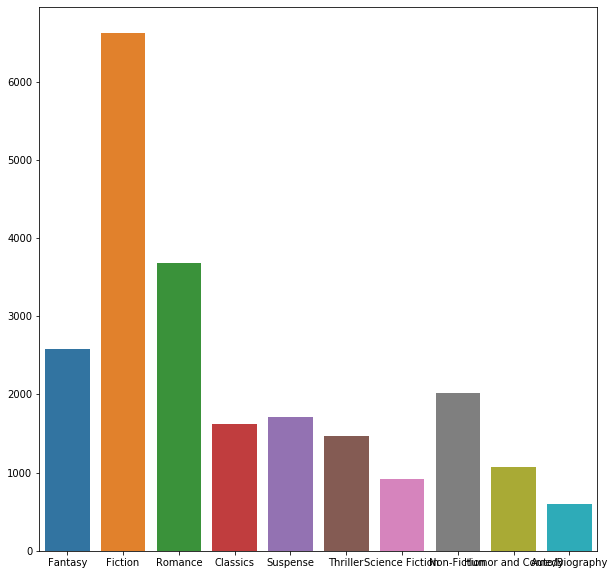

In [289]:
genrepoplist = pd.Series(data = c, index = c.keys())
fig, axes = plt.subplots(figsize = (10,10))
sns.barplot(x = genrepoplist.index, y = genrepoplist.values)

In [290]:
genrepoplist

Fantasy             2582
Fiction             6624
Romance             3684
Classics            1625
Suspense            1709
Thriller            1469
Science Fiction      915
Non-Fiction         2017
Humor and Comedy    1069
Auto/Biography       605
dtype: int64

We can see here that Fiction is the most popular genre and it encompasses almost 66 percent of the books. Although, this makes the data slightly less informative because sub-genre information is not very clear for all fiction books. A future task can be to not include fiction at all and introduce more sub genres to better identify the user's preferences.
Other that that, we see that people are reading more of Romance and fantasy novels. Non-fiction being such a vast generalization of various kinds of sub genres, still does not garner much popularity. Auto/biography are the least read but this could be attributed to the lower number of these books available in the market.

In [298]:
#Which genres of books are most highly rated?
bookgenresbyRating = pd.Series(index = c.keys())

for genre in bookgenresbyRating.index :
    bookgenresbyRating[genre] = books.groupby(genre).mean().loc[1]['Avg_Rating']

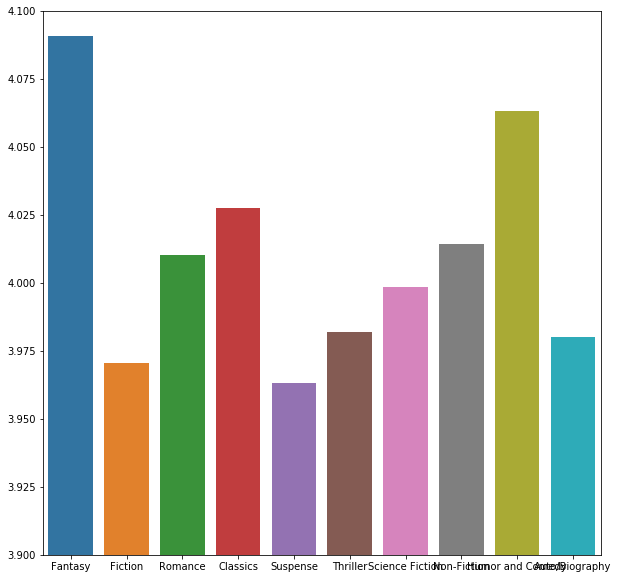

In [302]:
fig, axes = plt.subplots(figsize = (10,10))
axes.set(ylim=(3.9, 4.1))
sns.barplot(x = bookgenresbyRating.index, y = bookgenresbyRating.values)

In [303]:
bookgenresbyRating

Fantasy             4.090726
Fiction             3.970503
Romance             4.010469
Classics            4.027469
Suspense            3.963308
Thriller            3.982143
Science Fiction     3.998531
Non-Fiction         4.014308
Humor and Comedy    4.063376
Auto/Biography      3.980065
dtype: float64

The above analysis shows that fantasy is the top rated genre of books and fiction is the least rated genre of books by mean averaging principle. Fiction being the lowest is understandable as it includes many categories of books. Fantasy being the highest rated and also the most popular genre has some correlation. With the advent of movies based on popular fantasy books, people are reading more of this genre and are enjoying the fantastical/magical elements in the books. Also, generally these books are in a series of multiple books. If you read and enjoyed one book of the series, you are more likely to rate the other books of the series higher.                                                                                        
Assumption - We assume that we have covered genres of all books in this analysis. This is not true because the tags we have preset might not be present in some of the books. So they remain untagged. We can make this assumption because the preset tags are most popular so it should encompass most of popular books

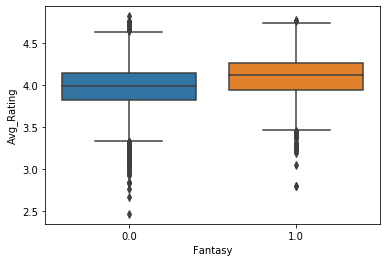

In [307]:
#Another idea can be to check the variance in ratings by each genre
ax = sns.boxplot(x="Fantasy", y="Avg_Rating", data=books)


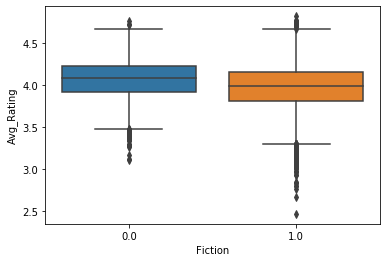

In [308]:
ax = sns.boxplot(x="Fiction", y="Avg_Rating", data=books)


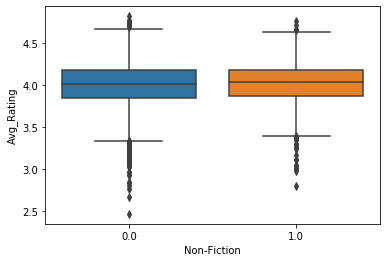

In [309]:
ax = sns.boxplot(x="Non-Fiction", y="Avg_Rating", data=books)


It looks from the Boxplots that variance of Non-fiction books is considerably less than fiction books. Lets look from std deviation data..

In [1]:
genreStdev = {}
for genre in genres:
    genreStdev[genre] = np.std(books[books[genre] == 1]['Avg_Rating'])
genreStdev


NameError: name 'genres' is not defined

Romance, Fiction, Humor are the main genres with more standard deviation while Thrillers, Non Fiction and suspense have lower std. This follows from the individual tastes of people where romance, fiction books might not appeal to all but thrillers/non-fiction have a comparatively more unified opinion. Still std is not that much to idicate any notable diffferences. Humor books with std 0.285 have the people most divided among all genres.

In [319]:
cleanRatings.to_csv("clean_Ratings")

In [16]:
books.to_csv("final_books_list")